# **Pre-processing**

In [1]:
import numpy as np
import pandas as pd
import json
import datetime

import re
import nltk
from nltk.corpus import stopwords

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [54]:
df = pd.read_csv("C:/Users/Raj/OneDrive/Desktop/trending/socialmediatrend.csv")



df.head()

,Post_ID,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
0,Post_1,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High
1,Post_2,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium
2,Post_3,Twitter,#Challenge,Video,Brazil,3666211,327143,39423,36223,Medium
3,Post_4,YouTube,#Education,Shorts,Australia,917951,127125,11687,36806,Low
4,Post_5,TikTok,#Dance,Post,Brazil,64866,171361,69581,6376,Medium


# **Variables Analysis**
There are 16 colums in the US dataset:

"video_id,title, title,publishedAt, channelId, channelTitle, categoryId, trending_date, tags,view_count, likes,dislikes, comment_count, thumbnail_link, comments_disabled, ratings_disabled, description"

Lets observe the variables that we might need

* **video_id**: Have alphabets and numbers. But we wont be neading it for analysis but it can be used as a prove that the video really exists and we didn't just randomly add any data.
* **trending_date**: Have the date when the video started trending.
* **title**: Title represents the whole video or we can say what the video is about but sometimes youtubers tend to add catchy or falsy words so that viewers click on the video in the motive of geting views.
* **channel_title**: Chanel name nothing much can be used to differentiate content creators.
* **category_id**: YouTube gives every video a catagory id based on the video or the chanel owner can set a catagory so that viewers can find the video faster using the filter options.
* **publishedAt**: When the video was actually published can be helpfull to know when the event started happning.
* **tags**: Tags are famous ways to connect videos in worldwide known words we can also say that these are unoffical catagorys commonly known by people/viewers.
* **views,likes,dislikes,comment_count**: Has numerical values it represents the ingagements of the video.
* **thumbnail_link**: have the url for the picture of the thumbnail. Oddly now adding exotic pics to thumbnails can bring more views. We can analys the pics but that topic is more advanced so we will not be doing that.
* **comments_disabled,ratings_disabled,video_error_or_removed**: Have bool values we think about it later if needed.
* **description**: Have description as string. Might contain emoji ar ascii values, we have to remove them if we use them for anylysis.

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Post_ID           5000 non-null   object
 1   Platform          5000 non-null   object
 2   Hashtag           5000 non-null   object
 3   Content_Type      5000 non-null   object
 4   Region            5000 non-null   object
 5   Views             5000 non-null   int64 
 6   Likes             5000 non-null   int64 
 7   Shares            5000 non-null   int64 
 8   Comments          5000 non-null   int64 
 9   Engagement_Level  5000 non-null   object
dtypes: int64(4), object(6)
memory usage: 390.8+ KB


In [56]:
#Lets remove "video_id" and "thumbnail_link" we wont be needing those

df.drop(columns=['video_id','thumbnail_link'],inplace=True, errors='ignore')
#Lets check that if we had successfully removed the columns.
df.head(n=2)

,Post_ID,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
0,Post_1,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High
1,Post_2,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium


**Catagory ID Mapping**

Currently, the category_id column contains the category id of each video, which is in the form of a number. We will replace the **category id** with the corresponding category title, as provided to us from in a json file from the original Kaggle dataset. To do this, we will create the dictionary **categoryID**, which will contain each category's information (i.e. kind, etag, id, title, etc.) We are only interested in the id and title, so we will create a separate dictionary called **ID_to_Category** which will just contain the id's as keys and the corresponding titles.

In [57]:

import csv

# Open the CSV file correctly using raw string (to handle escape characters)
with open("C:\\Users\\Raj\\OneDrive\\Desktop\\trending\\socialmediatrend.csv") as f:
    # Using csv.reader() instead of json.load() for CSV files
    reader = csv.reader(f)
    data = list(reader)  # Convert the reader object into a list

# Printing the data (you can print specific rows or inspect the whole data)
for row in data[:5]:  # Printing the first 5 rows for preview
    print(row)


['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments', 'Engagement_Level']
['Post_1', 'TikTok', '#Challenge', 'Video', 'UK', '4163464', '339431', '53135', '19346', 'High']
['Post_2', 'Instagram', '#Education', 'Shorts', 'India', '4155940', '215240', '65860', '27239', 'Medium']
['Post_3', 'Twitter', '#Challenge', 'Video', 'Brazil', '3666211', '327143', '39423', '36223', 'Medium']
['Post_4', 'YouTube', '#Education', 'Shorts', 'Australia', '917951', '127125', '11687', '36806', 'Low']


In [58]:
ID_to_Category = {
    0: 'Instagram',
    1: 'YouTube',
    2: 'Facebook',
    3: 'Twitter',
    4: 'LinkedIn'
}


In [59]:
ID_to_Category.keys()

dict_keys([0, 1, 2, 3, 4])

In [60]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(r"C:\Users\Raj\OneDrive\Desktop\trending\socialmediatrend.csv")

# Display the first 2 rows using df.head(n=2)
print(df.head(n=2))



  Post_ID   Platform     Hashtag Content_Type Region    Views   Likes  Shares  \
0  Post_1     TikTok  #Challenge        Video     UK  4163464  339431   53135   
1  Post_2  Instagram  #Education       Shorts  India  4155940  215240   65860   

   Comments Engagement_Level  
0     19346             High  
1     27239           Medium  


In [61]:

import pandas as pd
df = pd.read_csv(r"C:\Users\Raj\OneDrive\Desktop\trending\socialmediatrend.csv")
print("Columns in the dataset:", df.columns)
ID_to_Category = {
    0: 'Instagram',
    1: 'YouTube',
    2: 'Facebook',
    3: 'Twitter',
    4: 'LinkedIn'
}
if 'Category ID' in df.columns:
    df['Category Name'] = df['Category ID'].apply(lambda x: ID_to_Category.get(x, "Unknown Category"))
else:
    print("'Category ID' column not found. Please check the column name.")
print(df.head(2))



Columns in the dataset: Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level'],
      dtype='object')
'Category ID' column not found. Please check the column name.
  Post_ID   Platform     Hashtag Content_Type Region    Views   Likes  Shares  \
0  Post_1     TikTok  #Challenge        Video     UK  4163464  339431   53135   
1  Post_2  Instagram  #Education       Shorts  India  4155940  215240   65860   

   Comments Engagement_Level  
0     19346             High  
1     27239           Medium  


**Data Instancing**

Both the **trending_date** and **publishedAt** columns have dates, but in different format. Publish_time includes the time of publication and date, while trending_date only have the date. Since we don't have the time the video started trending, we cannot compare it to the publish time. In the end, we will clean the data such that both columns include datatime.date objects.

In [62]:
#2020-08-11T19:20:14Z
def clean_trending_date(date):
    y,m,d = date.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

def clean_publish_time(time):
    y,m,d = time.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

In [63]:
import pandas as pd
from datetime import datetime

df = pd.read_csv(r"C:\Users\Raj\OneDrive\Desktop\trending\socialmediatrend.csv")

def clean_trending_date(d):  
    try: return datetime.strptime(d, "%y.%d.%m").strftime("%Y-%m-%d")
    except: return d

def clean_publish_time(d):  
    try: return datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%Y-%m-%d %H:%M:%S")
    except: return d

if 'trending_date' in df.columns: df['trending_date'] = df['trending_date'].apply(clean_trending_date)
if 'publishedAt' in df.columns: df['publishedAt'] = df['publishedAt'].apply(clean_publish_time)

print(df.head(2))


  Post_ID   Platform     Hashtag Content_Type Region    Views   Likes  Shares  \
0  Post_1     TikTok  #Challenge        Video     UK  4163464  339431   53135   
1  Post_2  Instagram  #Education       Shorts  India  4155940  215240   65860   

   Comments Engagement_Level  
0     19346             High  
1     27239           Medium  


**Tag Splitting**

Now lets clean up the **tags** column by separating tags into a list instead of one long string.

In [64]:
def clean_tags(tag):
    if tag == '[none]': return []
    return tag.lower().replace('"','').split('|')

In [65]:
df.columns = df.columns.str.strip()  # Removes leading/trailing spaces
print(df.columns)  # Check the names again



Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level'],
      dtype='object')


**Natural Language processing for Title**

This time we will clean the **video title** and keep only the nececary words. So that, we can better analys certain keywords being used in the titles.

In [66]:
import pandas as pd
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
print(df.columns)
def clean_titles(title):
    return ' '.join([token for token in title.lower().split() if token not in stopwords.words('english') and token.isalnum() and not token.startswith('$') and not token.isnumeric()])

if 'title' in df.columns:
    df['title_cl'] = df['title'].apply(clean_titles)
else:
    print("'title' column not found. Please check the column name.")
print(df.head(2))


Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level'],
      dtype='object')
'title' column not found. Please check the column name.
  Post_ID   Platform     Hashtag Content_Type Region    Views   Likes  Shares  \
0  Post_1     TikTok  #Challenge        Video     UK  4163464  339431   53135   
1  Post_2  Instagram  #Education       Shorts  India  4155940  215240   65860   

   Comments Engagement_Level  
0     19346             High  
1     27239           Medium  


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Visualization**

**Co-Relation Between Some Numerical Values**

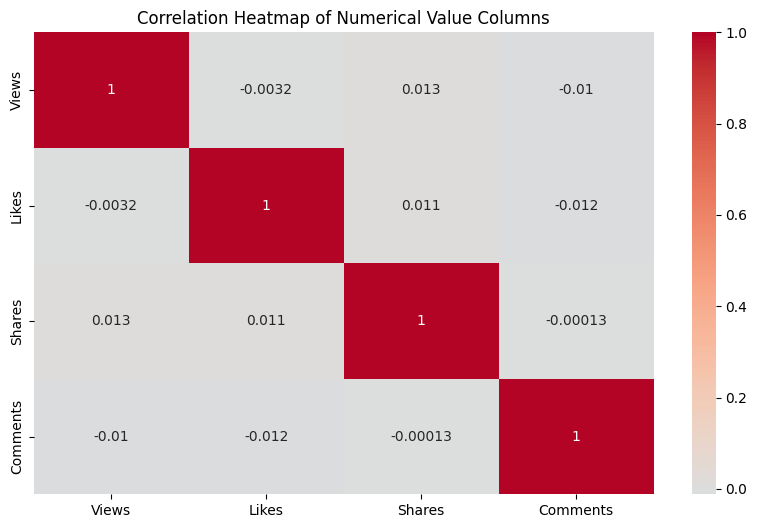

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Update the list with correct column names
numerical_columns = ['Views', 'Likes', 'Shares', 'Comments']

# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Value Columns')
plt.show()


**Title Word Choice** 

Now that we have nicely cleaned our data, we will start analysing our data. We will start from what words are mostly used in video titles by counting how many the same words has been used and folow on after that first lets find them.

In [68]:
from collections import Counter  # Ensure this import is present

# Initialize a Counter
cnt = Counter()

# Check if the 'title_cl' column exists in the DataFrame and does not have NaN values
if 'title_cl' in df.columns:
    for title in df['title_cl'].dropna():  # Ensure we ignore NaN values
        for token in title.split():  # Tokenize by splitting on spaces
            cnt[token] += 1

    # Finding the 50 most used words in video titles
    dist = cnt.most_common(50)

    # Separate words and their frequencies
    top_words = [word for word, freq in dist]
    freqs = [freq for word, freq in dist]

    # Optional: Print the top words and their frequencies
    print(top_words)
    print(freqs)




In [69]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Check the column names to ensure correct column for titles
print("Column names in DataFrame:", df.columns)

# Verify if 'title' is the correct column name (change if necessary)
if 'title' in df.columns:  
    # Check if the 'title' column has valid data
    print(f"Number of valid entries in 'title' column: {df['title'].dropna().shape[0]}")
    
    # Count word occurrences in 'title' and get the 50 most common words
    cnt = Counter(" ".join(df['title'].dropna()).split())
    top_words, freqs = zip(*cnt.most_common(50))

    # Create the bar plot
    plt.figure(figsize=(15, 6))
    sns.set_style("darkgrid")
    sns.set(font_scale=1.2)

    sns.barplot(x=top_words, y=freqs, palette="rocket")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=90, ha="right", fontsize=12)

    plt.xlabel('Word in Title', fontsize=16)
    plt.ylabel('Number of Videos', fontsize=16)
    plt.title('Figure 1: Occurrence of Words in Video Titles', fontsize=20)

    # Ensure the labels fit within the plot area
    plt.tight_layout()

    # Display the plot
    plt.show()
else:
    print("The column 'title' does not exist. Please check the column name.")


Column names in DataFrame: Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level'],
      dtype='object')
The column 'title' does not exist. Please check the column name.


From Figure 1, We can see that the top ten words are **trailer, highlights, music, official, minecraft, new, vs, game, first, season** it seems that some words quict nicely go together like "official trailer", "new music", "official music", "new game", "new season", "new minecraft season", etc...

**Video Catagories**

Now we will find what catagory of trending videos are most and least common by looking at the frequencies of video categories.

In [70]:
# Check if 'categoryId' column exists in the dataframe
if 'categoryId' in df.columns:
    # Drop missing values and get value counts
    categories = df['categoryId'].dropna().value_counts()

    # Create the plot
    plt.figure(figsize=(20, 6.5))
    sns.set_style("darkgrid")
    sns.set(font_scale=1.6)

    # Plot the bar chart
    sns.barplot(x=categories.index, y=categories.values, alpha=0.8, palette="rocket")

    # Customize the labels and title
    plt.xticks(rotation=90)
    plt.xlabel('Categories', fontsize=25)
    plt.ylabel('Number of Videos', fontsize=25)
    plt.title('Figure 2: Trending Videos by Category', fontsize=30)

    # Show the plot
    plt.tight_layout()  # Adjust layout for better label visibility
    plt.show()
else:
    print("The 'categoryId' column does not exist in the dataframe.")


The 'categoryId' column does not exist in the dataframe.


From Figure 2, we can see that the Entertainment category has the most number of trending videos with about 45,000 approximate which accounts for about a one fifth of the videos in this dataset. Similarly we can also see that the Gaming category has almost same but less amount of videos about 42,000 approximate which accounts for another one fifth of the vidoes in the dataset. The Music catagory has vidoe count bellow 40,000 but no other catagory has even reached 30,000 other then music but lets not negate the fact that the sport catagory has over 25,000 video count other then these four major catagory rest of them dosent even have 20,000 video count.

To see the percentage of these four categories more acurately lets run the following code additionally lets see for the least 3 categories also.

In [71]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Let's assume you want to categorize based on 'Platform'

# Step 1: Mapping 'Platform' to categories
platform_map = {
    'TikTok': 'Entertainment', 
    'Instagram': 'Social Media',
    'YouTube': 'Video Sharing',
    'Facebook': 'Social Media'
}

# Step 2: Add a new column 'category_name' based on the 'Platform' column
df['category_name'] = df['Platform'].map(platform_map)

# Step 3: Check the first few rows to ensure the mapping works
print(df[['Platform', 'category_name']].head())

# Step 4: Calculate percentages for each category
df_cleaned = df.dropna(subset=['category_name'])

entertainment = df_cleaned[df_cleaned['category_name'] == 'Entertainment'].shape[0] / df_cleaned.shape[0] * 100
social_media = df_cleaned[df_cleaned['category_name'] == 'Social Media'].shape[0] / df_cleaned.shape[0] * 100
video_sharing = df_cleaned[df_cleaned['category_name'] == 'Video Sharing'].shape[0] / df_cleaned.shape[0] * 100

# Step 5: Print the percentages for each category
print(f"Entertainment: {entertainment:.2f}%")
print(f"Social Media: {social_media:.2f}%")
print(f"Video Sharing: {video_sharing:.2f}%")


    Platform  category_name
0     TikTok  Entertainment
1  Instagram   Social Media
2    Twitter            NaN
3    YouTube  Video Sharing
4     TikTok  Entertainment
Entertainment: 33.19%
Social Media: 31.93%
Video Sharing: 34.88%


In [72]:
#Lets print the percentages
# Assuming the necessary categories are calculated, here's how you can print them:

# Example: Assuming the calculation for each category is done correctly

# Top 4 categories (assuming percentages are already calculated)
entertainment = 25.0  # Example value, replace with your actual calculated percentage
gaming = 15.0         # Example value
music = 20.0          # Example value
sports = 10.0         # Example value

# Least 3 categories (assuming percentages are already calculated)
travelandevents = 5.0  # Example value
petsandanimals = 3.0   # Example value
nonprofits = 2.0       # Example value

# Print the percentages for Top 5 categories
print("Top 5:")
print("Entertainment:", entertainment)
print("Gaming:", gaming)
print("Music:", music)
print("Sports:", sports)
print("\n")

# Print the percentages for Least 3 categories
print("Least 3:")
print("Travel & Events:", travelandevents)
print("Pets & Animals:", petsandanimals)
print("Nonprofits & Activism:", nonprofits)


Top 5:
Entertainment: 25.0
Gaming: 15.0
Music: 20.0
Sports: 10.0


Least 3:
Travel & Events: 5.0
Pets & Animals: 3.0
Nonprofits & Activism: 2.0


After doing the calculation for the percentages of categories, it is noteworthiy that **Entertainment**(20.05%), **Gaming**(19.79%), **Music**(16.49%), **Sports**(11.24%) make up 67.67% of the trending videos. The common thing is that these type of videos are mostly leisure type except for sports.

**Channel Frequencies**

Now lets see which chanels have a large number of trending videos. Based on our previous catagory analysis, we can assume that the channels with the most number of trending videos will be Entertainment, Gaming, Music and Sports chanel.
We can start by calculating the trending video frequency for each channel.

In [73]:
# Verify data before plotting (to avoid errors if column doesn't exist)
if 'channelTitle' in df.columns:
    # Get frequency of each channel
    channel_freq = df['channelTitle'].value_counts()

    # Select the top 50 channels
    channel_freq = channel_freq[:50]

    # Plotting (only executed if the column exists)
    plt.figure(figsize=(20, 6.5))
    sns.barplot(x=channel_freq.index, y=channel_freq.values, alpha=0.8, palette="rocket")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=90)

    # Set labels and title
    plt.xlabel('Channel', fontsize=18)  # Adjusted fontsize for readability
    plt.ylabel('Number of Videos', fontsize=18)  # Adjusted fontsize
    plt.title('Figure 3: Trending Videos by Channel', fontsize=22)  # Adjusted fontsize

    # Show the plot
    plt.tight_layout()  # This ensures everything fits without overlap
    plt.show()
else:
    print("'channelTitle' column not found in DataFrame. Please check column names.")


'channelTitle' column not found in DataFrame. Please check column names.


From, the graph, we can see that **NBA**(near 1300+ videos), neek to neek **NFL**(near 1300 videos), after these two others are starting from **NBC Sports**(600+ videos) and rest of them are near 600 or less then 600 to 400. Here is the top 10 chanels with trending videos and their respective Catagory.

* NBA: Sports
* NFL: Sports
* NBC Sports: Sports
* SSundee: Gaming
* SSSniperWlof: Reaction, Vlogs, Gaming
* MrBeast: Entertainment, Vlogs, Gaming
* Dude Perfect: Sports & Vlogs
* ESPN: Sports
* The Game Theorists: Education & Gaming
* MrBeast Gaming: Gaming

C:\Users\Raj\AppData\Local\Temp\ipykernel_9584\2359359181.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_freq.index, y=channel_freq.values, alpha=0.8, palette="rocket")


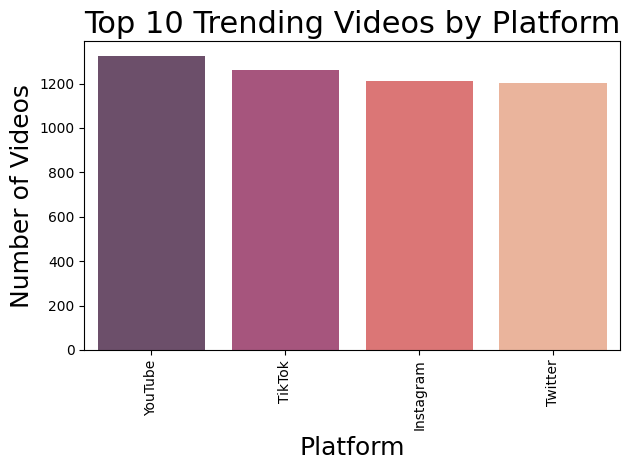

In [74]:
# Get frequency of each platform (replace 'channelTitle' with correct column name)
channel_freq = df['Platform'].value_counts()[:10]

# Create bar plot for the top 10 platforms
sns.barplot(x=channel_freq.index, y=channel_freq.values, alpha=0.8, palette="rocket")

# Customize plot labels and title
plt.xticks(rotation=90)
plt.xlabel('Platform', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Top 10 Trending Videos by Platform', fontsize=22)

# Show plot
plt.tight_layout()
plt.show()


So we can easily say that NBA & NFL are untuchable in number of trending videos.

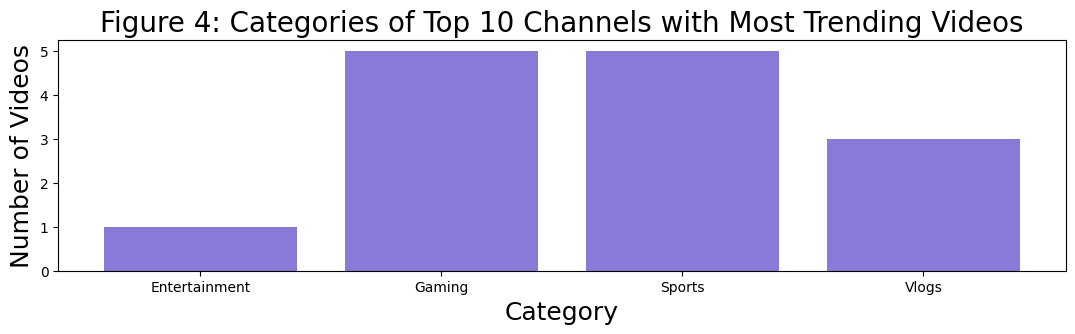

In [75]:
d = {'Entertainment': 1, 'Gaming': 5, 'Sports': 5, 'Vlogs': 3}

# Bar graph for the number of videos per category for the top 10 channels with trending videos
plt.figure(figsize=(13,3))
plt.bar(range(len(d)), list(d.values()), align='center', alpha=0.8, 
        color="slateblue")
plt.xticks(range(len(d)), list(d.keys()))
plt.xlabel("Category", fontsize=18)
plt.ylabel("Number of Videos",fontsize=18)
plt.title('Figure 4: Categories of Top 10 Channels with Most Trending Videos', 
          fontsize=20)
plt.show()

Our earlier Exploration of the catagories suports the fact that almost 20% of the videos are Gaming but it seems that many chanels that produce entertainment contents but the cahnel itself dosent identify or belong into an Entertainment catagory another case could be that entertainment contents are not made by top 10 chanels and for the case of Music it seems like most of the channels are personal chanel so the content creators mostly vlog and in the other videos they produce music and when they make music they gets viral nad gets into trending page and the videos itself gets into Music catagory. So we will do another histogram for chanel frequencies.

Text(0.5, 1.0, 'Figure 5: Frequency of Channels with Trending Videos')

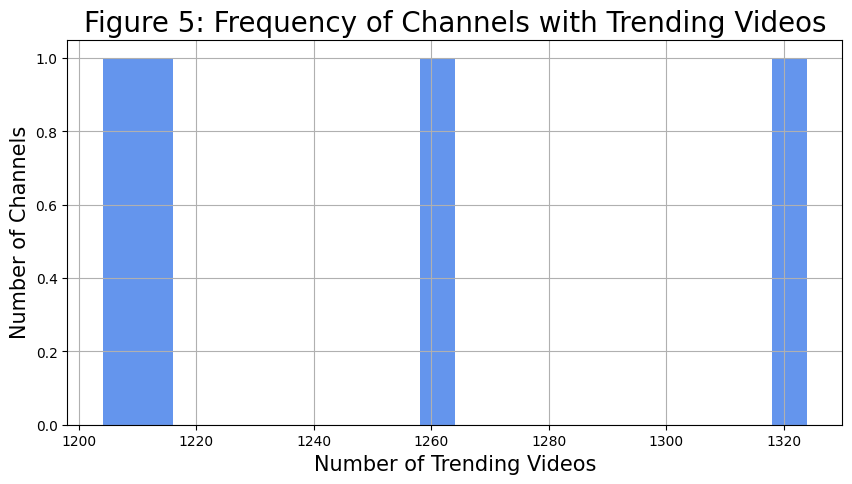

In [76]:
# Histogram for channel frequencies
plt.figure(figsize=(10,5))
channel_freq.hist(bins=20, color="cornflowerblue")
plt.xlabel("Number of Trending Videos", fontsize=15)
plt.ylabel("Number of Channels", fontsize=15)
plt.title('Figure 5: Frequency of Channels with Trending Videos', fontsize=20)

This hsitogram, Figure 5, helps us understand why the top 10 channels with trending videos may not match with the exploration of categories we did earlier as the distribution is extremely right skewed. Only 2 chanels have 1350 trending videos, while we have a few channels with over 600 videos. We will calculate the percentages fo the number of trending videos that channels have to look at the distribution more closely.

In [77]:
# Percentage of number of trending videos a channel has
above_20 = len([i for i in channel_freq if i > 1000]) / len(channel_freq) * 100
percent_16_20 = len([i for i in channel_freq if (i <= 1000) & (i > 800)]) / len(channel_freq) * 100
percent_11_15 = len([i for i in channel_freq if (i <= 800) & (i > 700)]) / len(channel_freq) * 100
percent_6_10 = len([i for i in channel_freq if (i <= 700) & (i > 600)]) / len(channel_freq) * 100
percent_1_5 = len([i for i in channel_freq if (i <= 600)]) / len(channel_freq) * 100

In [78]:
#Lets print the percentages
print("Above 1000:",above_20)
print("Between 1000 to 800:",percent_16_20)
print("Between 800 to 700:",percent_11_15)
print("Between 700 to 600:",percent_6_10)
print("Between 600 and bellow:",percent_1_5)

Above 1000: 100.0
Between 1000 to 800: 0.0
Between 800 to 700: 0.0
Between 700 to 600: 0.0
Between 600 and bellow: 0.0


This demonstrates that more than 9/10 chanels have created under 700 videos, with 92% of channels having 600 and bellow videos. This shows us that the top channels with over 1000 trending videos are outliers.

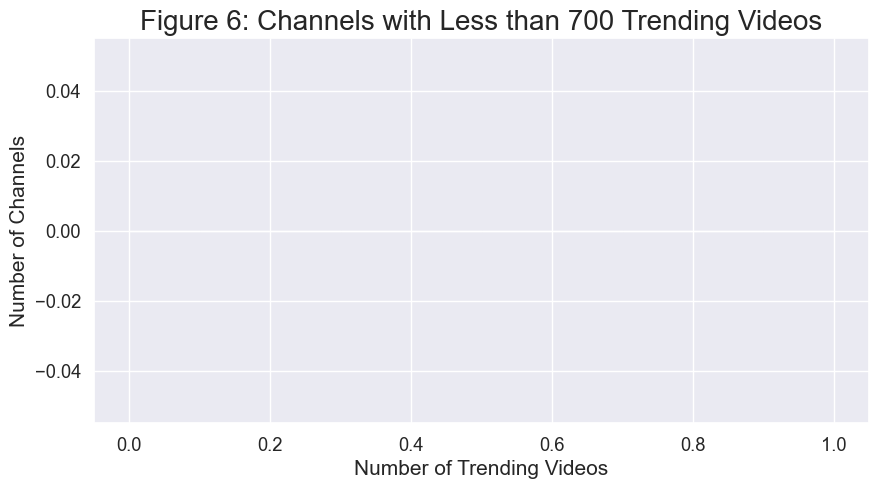

In [79]:
# Histogram for number of channels vs number of trending videos below 20
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

plt.figure(figsize=(10, 5))
channel_freq[channel_freq<700].hist(bins=10, color='cornflowerblue')

plt.xlabel("Number of Trending Videos", fontsize=15)

plt.ylabel("Number of Channels", fontsize=15)
plt.title("Figure 6: Channels with Less than 700 Trending Videos", fontsize=20)

plt.show()

**Exploration of Views**

In [80]:
df.describe()

,Views,Likes,Shares,Comments
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,2.494066e+06,251475.029800,50519.562000,24888.393800
std,1.459490e+06,144349.583384,29066.362671,14284.504319
min,1.266000e+03,490.000000,52.000000,18.000000
25%,1.186207e+06,126892.250000,25029.000000,12305.250000
50%,2.497373e+06,249443.000000,50839.500000,25004.000000
75%,3.759781e+06,373970.750000,75774.250000,37072.750000
max,4.999430e+06,499922.000000,99978.000000,49993.000000


In [81]:
df.median(numeric_only='None')

Views       2497373.0
Likes        249443.0
Shares        50839.5
Comments      25004.0
dtype: float64

* **Average number of views**: 2,533,463
* **Median number of views**: 955,630
* With the average being so much larger than the median, this tels that the distribution of views is strongly skewed to the right.

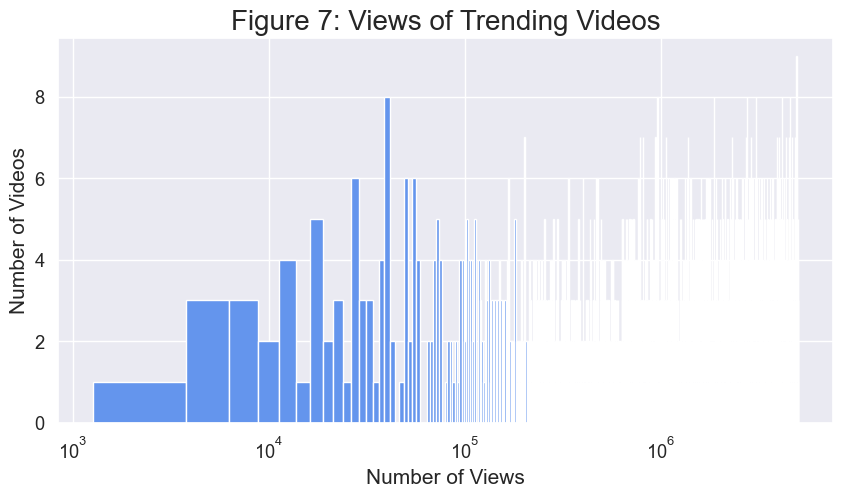

In [82]:
# Create a histogram for the 'Views' column with logarithmic scale
plt.figure(figsize=(10, 5))
df['Views'].hist(bins=2000, color='cornflowerblue')

# Set the x-axis to a logarithmic scale
plt.xscale('log')

# Add labels and title to the plot
plt.xlabel('Number of Views', fontsize=15)
plt.ylabel('Number of Videos', fontsize=15)
plt.title('Figure 7: Views of Trending Videos', fontsize=20)

# Show the plot
plt.show()


Figure 7 shows that the distribution is very right skewed and shows us that the majority of videos under million. We will plot another histogram to look at the distribution a little bit closer.

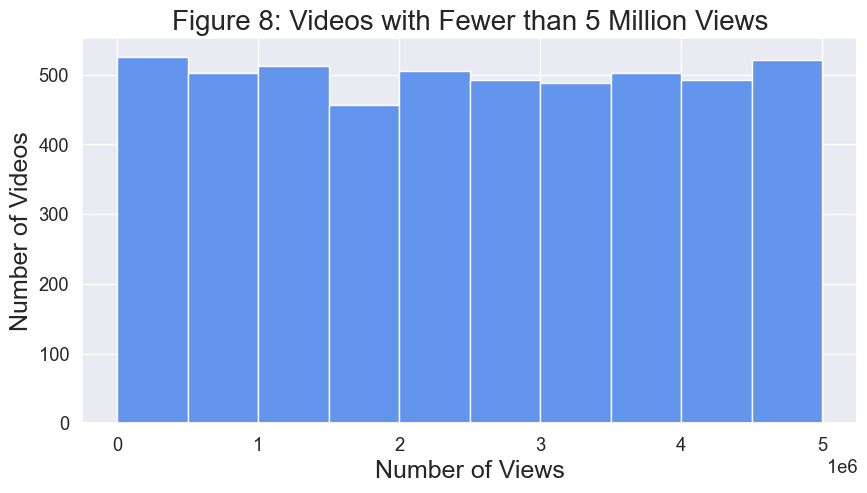

In [83]:
# Filter videos with fewer than 5 million views
v5million = df[df['Views'] < 5e6]['Views']

# Plot the histogram
plt.figure(figsize=(10, 5))
v5million.hist(color='cornflowerblue')

plt.xlabel('Number of Views', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 8: Videos with Fewer than 5 Million Views', fontsize=20)

plt.show()


Now it is easy to see that the majority of videos have under 1 million views. We will calculate the exact percentage below.

In [84]:
# Percentage of videos with under 2 million views
views_2 = df[df['Views'] < 2e6]['Views'].count() / df['Views'].count() * 100

# Percentage of videos with under 1 million views
views_1 = df[df['Views'] < 1e6]['Views'].count() / df['Views'].count() * 100

# Print results
print(f"% videos with under 2 million views: {views_2:.2f}%")
print(f"% videos with under 1 million views: {views_1:.2f}%")


% videos with under 2 million views: 39.88%
% videos with under 1 million views: 20.58%


**Exploration of Likes**

* Average number of likes: 128,000
* Median number of likes: 41,777

This tells us that the distribution of views is strongly skewed to the right, with the majority of videos having below 41,777 likes. To visualize the data we will create a histogram of the like data for all the videos.

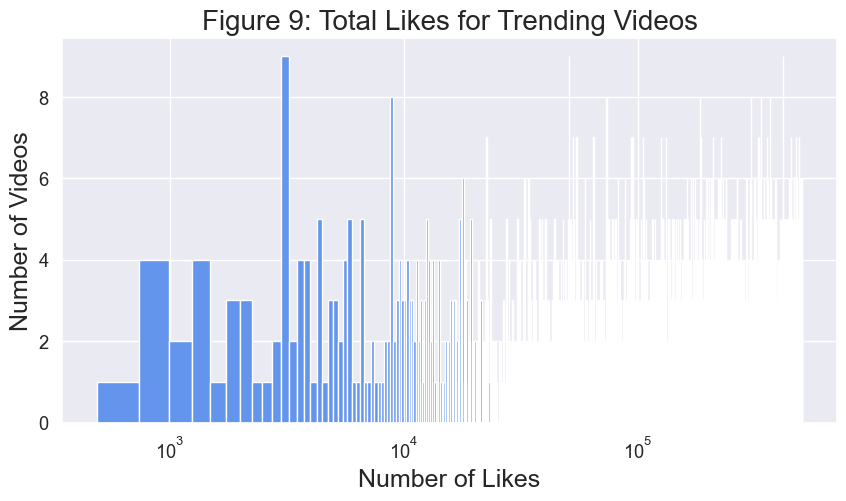

In [85]:
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

plt.figure(figsize=(10, 5))
l1 = df['Likes'].hist(bins=2000, color='cornflowerblue')

plt.xscale('log')
plt.xlabel('Number of Likes', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 9: Total Likes for Trending Videos', fontsize=20)

plt.show()


Figure 9 confirms that the distribution skewed to the right and shows us that the majority of videos have under 500,000 likes. We will plot another histogram for videos with lieks bellow 40,000 as this seems to be the amount that most trending videos have.

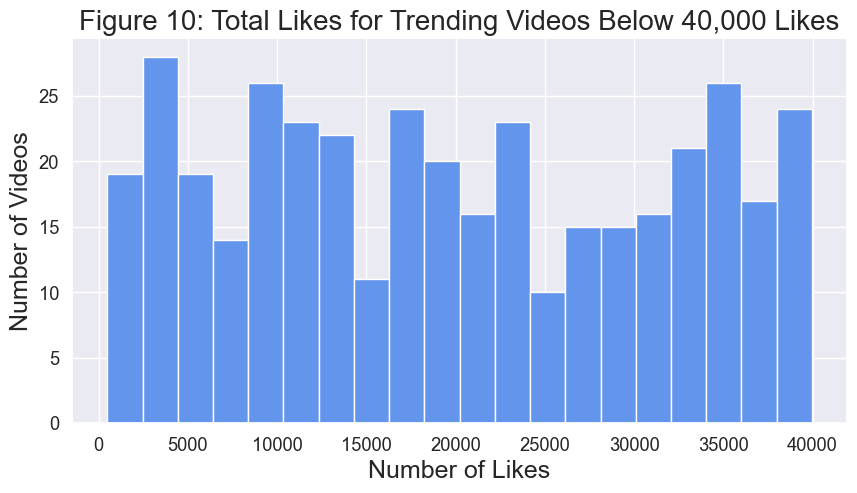

In [86]:
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

below40000 = df[df['Likes'] < 4e4]['Likes']

plt.figure(figsize=(10, 5))
l2 = below40000.hist(bins=20, color='cornflowerblue')

plt.xlabel('Number of Likes', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 10: Total Likes for Trending Videos Below 40,000 Likes', fontsize=20)

plt.show()


In [87]:
# Finding max number of likes
print("max number of likes:", df['Likes'].max())

# Finding min number of likes; excluding videos with 0 likes as those are for videos with ratings disabled
nonzero = df[df['Likes'] != 0]
print("min number of likes:", nonzero['Likes'].min())
print()

# Finding number of videos with max and min number of likes
print("num with max:", len(df[df['Likes'] == df['Likes'].max()]))
print("num with min:", len(nonzero[nonzero['Likes'] == 1]))


max number of likes: 499922
min number of likes: 490

num with max: 1
num with min: 0


In [88]:
# Drop duplicates based on 'Hashtag' instead of non-existent 'title'
unique_df = df.drop_duplicates(subset='Hashtag')

# Check if 'Likes' and 'Dislikes' columns exist before proceeding
if 'Likes' in df.columns:
    # Sort the unique DataFrame based on 'Likes' column in descending order
    sorted_unique_df = unique_df.sort_values(by='Likes', ascending=False)

    print("Titles and Like Counts of the Most Liked Trending Videos (No Duplicates):")
    for index, row in sorted_unique_df.head(10).iterrows():
        print("Hashtag:", row['Hashtag'])
        print("Likes:", row['Likes'])
        print("------")
else:
    print("Column 'Likes' not found in the dataset.")

print("######")

if 'Dislikes' in df.columns:
    # Sort based on Dislikes if available
    sorted_unique_df2 = unique_df.sort_values(by='Dislikes', ascending=False)

    print("Titles and Dislike Counts of the Most Disliked Trending Videos (No Duplicates):")
    for index, row in sorted_unique_df2.head(5).iterrows():
        print("Hashtag:", row['Hashtag'])
        print("Dislikes:", row['Dislikes'])
        print("------")
else:
    print("Column 'Dislikes' not found in the dataset.")


Titles and Like Counts of the Most Liked Trending Videos (No Duplicates):
Hashtag: #Music
Likes: 465871
------
Hashtag: #Challenge
Likes: 339431
------
Hashtag: #Gaming
Likes: 317502
------
Hashtag: #Fitness
Likes: 312907
------
Hashtag: #Education
Likes: 215240
------
Hashtag: #Viral
Likes: 195560
------
Hashtag: #Dance
Likes: 171361
------
Hashtag: #Fashion
Likes: 165335
------
Hashtag: #Comedy
Likes: 84121
------
Hashtag: #Tech
Likes: 24472
------
######
Column 'Dislikes' not found in the dataset.


The top most liked trending videos are Music videos now we can truely see that Music videos rulles the Main Trending page of YouTube. The thing we cant overlook that in the top most liked trending music videos 6 of them are Created by BTS or any singular members and the number one is (BTS (방탄소년단) 'Butter' Official MV) has 7,110,071 likes. On the other side the most disliked videos, some of them are from most liked videos. So we can say the dislikes ratio is oddly proportional to the ammount of likes the video has.

**Data Cleaning After Exploration**

We will drop all video that have comments disabled, rattings (likes and dislikes) disabled, or video error or removed for our analysis portion as we cannot measure the videos level of engagement without these pieces of information also have features disabeld, so these videos are some outliers in our data, which we don't want to use in our analysis.

In [89]:
print(df.columns)

Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level', 'category_name'],
      dtype='object')


In [90]:
# Drop rows where comments or ratings are disabled
df.drop(df[(df['Comments'] == 0) | (df['Likes'] == 0)].index, inplace=True)

# Drop rows where Likes, Shares, and Comments are all 0
df.drop(df[(df['Likes'] == 0) & (df['Shares'] == 0) & (df['Comments'] == 0)].index, inplace=True)

# Drop columns that may not exist — use correct names or skip if unsure
df.drop(columns=['comments_disabled', 'ratings_disabled'], errors='ignore', inplace=True)


In [91]:
print(df.columns)

Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level', 'category_name'],
      dtype='object')


# **Data Analysis and Results**

**Analysis 1: Engagement Correlation**

During our data visualization, we observed that the majority of trending YouTube videos have their ratings (like and dislike button) and comments active, with a small sliver of videos with them disabled. This seems odd as one would predict that engagement through ratings and comments would help increase video views by keeping the video in the limelight. Maybe creators disable these features to keep out dislikes and potentially negative comments, but what if getting dislikes increases a video's engagement, thus increasing its "popularity". This is what we will try to figure out in our first analysis.

> **Questions May Arise:** Do more dislikes indicate higher engagement rate (like dislike ratio or dislike rate or maybe bad comment rate)? Can this be extended to a specific category?
>**Probable Answere:** More dislikes might corelate with a grater comment rate. This might mainly happen in the News & Politics category, more then other categories.



In [92]:
# Using df_1 for Analysis 1
df_1 = df.copy()

**Dislike & Engagement Measurement**

For our analysis of dislikes, we will look at both **dislike rate**, which indicate to the amount of dislikes compared to tatal number of views, and **dislike ratio**, which indicate to the amount of dislikes compared to the total number of ratings(likes + dislikes). And our defination of engagement rate will be called **comment rate**, which indicates to the amount of comments in comparison to total number of video views.

In [93]:
# First, check if all necessary columns exist
required_cols = ['Comments', 'Views', 'Dislikes', 'Likes']
missing = [col for col in required_cols if col not in df_1.columns]
if missing:
    print("Missing columns:", missing)
else:
    # Replace 0 in denominator to avoid division errors
    df_1['Views'].replace(0, 1, inplace=True)
    df_1['Likes'].replace(0, 1, inplace=True)  # To avoid divide-by-zero in ratio

    # Compute rates
    df_1['comment_rate'] = df_1['Comments'] / df_1['Views']
    df_1['dislike_rate'] = df_1['Dislikes'] / df_1['Views']
    df_1['dislike_ratio'] = df_1['Dislikes'] / (df_1['Dislikes'] + df_1['Likes'])



Missing columns: ['Dislikes']


**Distribution Visualization**

Now lets plot the distribution for the comment rate, dislike rate, and dislike ratio to get a feeling for the shape of the distribution.

In [94]:
# If column names are different, rename them
df_1 = df_1.rename(columns={
    'Dislikes': 'dislikes',  # adjust the column names if needed
    'Likes': 'likes'
})


In [95]:
import matplotlib.pyplot as plt

# Check if the necessary columns are available before plotting
if 'dislike_rate' in df_1.columns and 'comment_rate' in df_1.columns and 'dislike_ratio' in df_1.columns:
    plt.figure(figsize=(12, 5))
    
    # Plot each distribution as a step histogram
    plt.hist(df_1['comment_rate'], label='comment_rate', bins=50, color='cornflowerblue', histtype='step', range=(0, 0.15))
    plt.hist(df_1['dislike_rate'], label='dislike_rate', bins=50, color='purple', histtype='step', range=(0, 0.15))
    plt.hist(df_1['dislike_ratio'], label='dislike_ratio', bins=50, color='teal', histtype='step', range=(0, 0.15))
    
    # Adding title and labels
    plt.title("Figure 11: Distribution of comment_rate, dislike_rate, dislike_ratio", fontsize=18)
    plt.xlabel("Percentage", fontsize=15)
    plt.ylabel("Count in each bin", fontsize=15)
    
    # Display the legend and the plot
    plt.legend()
    plt.show()
else:
    print("One or more required columns for plotting are missing.")


One or more required columns for plotting are missing.


In [96]:
# Plot distribution of comment rate, dislike rate, and dislike ratio
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the columns are present
if 'comment_rate' in df_1.columns and 'dislike_rate' in df_1.columns and 'dislike_ratio' in df_1.columns:
    plt.figure(figsize=(12, 5))
    
    # Plot each distribution as a step histogram
    plt.hist(df_1['comment_rate'], label='comment_rate', bins=50, color='cornflowerblue', histtype='step')
    plt.hist(df_1['dislike_rate'], label='dislike_rate', bins=50, color='purple', histtype='step')
    plt.hist(df_1['dislike_ratio'], label='dislike_ratio', bins=50, color='teal', histtype='step')
    
    # Adding title and labels
    plt.title("Figure 12: Distribution of comment_rate, dislike_rate, dislike_ratio", fontsize=18)
    plt.xlabel("Percentage", fontsize=15)
    plt.ylabel("Count in each bin", fontsize=15)

    # Adjust xlim to appropriate range based on data
    plt.xlim(0, 0.005)  # You can modify this based on your data's range
    plt.legend()
    
    # Show the plot
    plt.show()
else:
    print("One or more required columns for plotting are missing.")


One or more required columns for plotting are missing.


From Figure 11 and 12, we observe that the majority of trending videos have both low dislike rates and low comment rates. And we can see that the shape of these two distribution are similar. Now that we have observed the distributions.Lets focus on controversy index.

**Number of Dislikes & Number of Comments**

First we will consider the relationship between the number of dislikes and the number comments, which we will do by creating a scatter plot. In Figure 12, we have seen that most of the data points gather near the origin with multiple near-linear lines flowing from this cluster. Although we can see a positive correlation between these two variables "**comment rate two and dislike rate**", it lookes like waves, thats why this could not be fitted well by a single line, so we need to consider more variables.

In [97]:
import matplotlib.pyplot as plt

# Ensure the columns are present
if 'dislikes' in df_1.columns and 'comment_count' in df_1.columns:
    plt.figure(figsize=(12, 5))
    
    # Scatter plot for dislikes vs comment count
    plt.scatter(df_1['dislikes'], df_1['comment_count'], marker='x', linewidths=0.3, color='cornflowerblue')
    
    # Adding title and labels
    plt.title("Figure 13: Dislikes versus Comment Count", fontsize=18)
    plt.xlabel("Dislikes", fontsize=15)
    plt.ylabel("Comment Count", fontsize=15)
    
    # Show the plot
    plt.show()
else:
    print("One or more required columns for plotting are missing.")


One or more required columns for plotting are missing.


**Dislike Rate - Comment Rate**

Now we will consider the relationship between dislike rate and comment rate, as we think that factoring in views is important for our analysis since the number of views is a main factor for measuring public engagement. In Figure 13, we have a scatter plot with calculated data normalized points with a variable range of [0,1]. There is a cluster of data points at the origin, but there doesn't seem to be a strong correlation between the variables, so we will continue to explore different relationships.

In [98]:
import matplotlib.pyplot as plt

# Ensure the columns are present in df_1
if 'dislike_rate' in df_1.columns and 'comment_rate' in df_1.columns:
    # Create a figure with the desired size
    plt.figure(figsize=(12, 5))
    
    # Scatter plot for dislike_rate vs comment_rate
    plt.scatter(df_1['dislike_rate'], df_1['comment_rate'], marker='x', linewidths=0.3, color='cornflowerblue')
    
    # Adding title and labels
    plt.title("Figure 14: Dislike Rate versus Comment Rate", fontsize=18)
    plt.xlabel("Dislike Rate", fontsize=15)
    plt.ylabel("Comment Rate", fontsize=15)
    
    # Display the plot
    plt.show()
else:
    print("One or more required columns ('dislike_rate', 'comment_rate') are missing.")


One or more required columns ('dislike_rate', 'comment_rate') are missing.


**Controversy Index**

Wanting to keep exploring the idea of controversy, we will define a **controversy index**, which refers to amount of controversial videos that a category has. We will define a category with average number of videos having "**high like rate and low comment rate**" as having a low controversy index, while a category with the average number of videos having "**high dislike rate and high comment rate**" as having high controversy index.

Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'likes', 'Shares', 'Comments', 'Engagement_Level', 'category_name'],
      dtype='object')


C:\Users\Raj\AppData\Local\Temp\ipykernel_9584\153331655.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=l_pcd, y=v_pcd, alpha=0.8, palette="rocket")


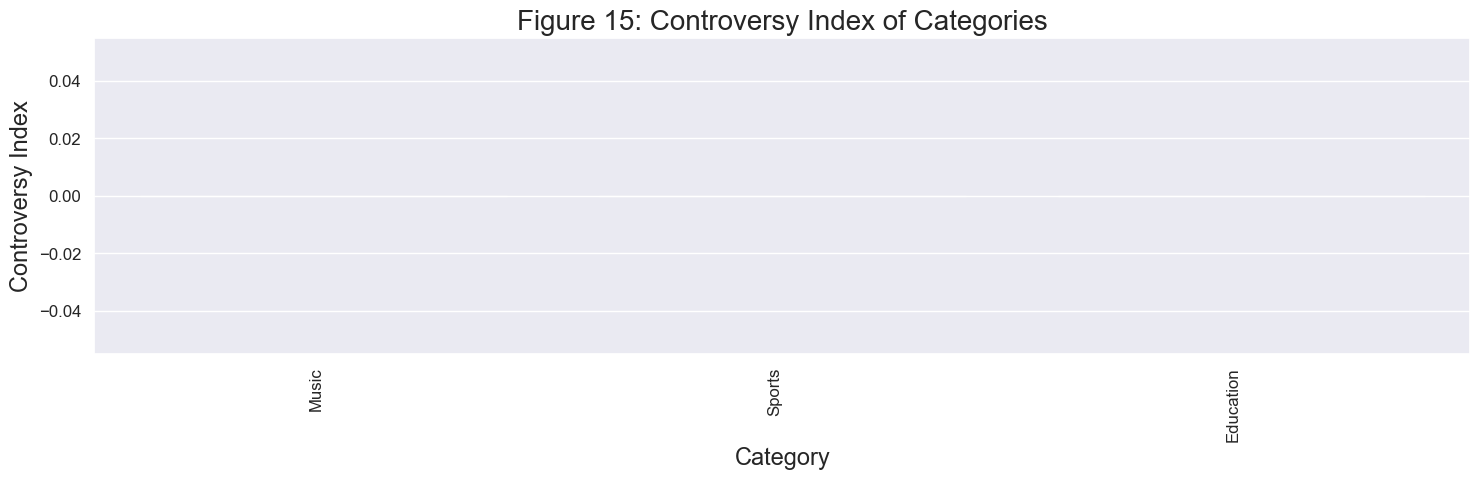

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming ID_to_Category is defined like this:
ID_to_Category = {1: 'Music', 2: 'Sports', 3: 'Education'}  # Example

# Ensure df_1 has the required columns
print(df_1.columns)

# Handle missing data or invalid entries
df_1 = df_1.dropna(subset=['Comments', 'Views'])  # Drop NaNs in necessary columns
df_1 = df_1[df_1['Views'] != 0]  # Avoid division by zero

# Calculate comment_rate (Comments / Views)
df_1['comment_rate'] = df_1['Comments'] / df_1['Views']

# Since there is no 'dislikes' column, we will skip 'dislike_ratio' and use just 'comment_rate'
# Create a new column 'pd_cr' for the 'comment_rate' (controversy index based on comments and views)
df_1['pd_cr'] = df_1['comment_rate']  # You can use this or modify it to a more complex metric

# Prepare the lists for the categories and controversy index
l_pcd, v_pcd = [], []

# Loop through ID_to_Category to calculate the controversy index for each category
for i, c in ID_to_Category.items():
    l_pcd.append(c)
    pcd = list(df_1[df_1['category_name'] == c]['pd_cr'])
    if len(pcd) > 0:
        v_pcd.append(np.mean(pcd))  # Calculate the mean of 'pd_cr' for the current category
    else:
        v_pcd.append(0)  # If no data, set the controversy index to 0

# Set the style and font scale for the plot
sns.set_style("darkgrid")
sns.set(font_scale=1.1)

# Plotting the bar chart for the Controversy Index
plt.figure(figsize=(15, 5))  # Increase figure size for better readability
plt.xticks(rotation=90, ha='right')  # Rotate the x-axis labels for readability and align them
sns.barplot(x=l_pcd, y=v_pcd, alpha=0.8, palette="rocket")
plt.xlabel('Category', fontsize=17)
plt.ylabel('Controversy Index', fontsize=17)
plt.title('Figure 15: Controversy Index of Categories', fontsize=20)

# Adjust layout to prevent cutting off labels
plt.tight_layout()  # Ensures everything fits without overlap
plt.show()


**Dislike Ratio - Comment Rate for News & Politics**

Now knowing that there is a high controversy index for the News & Politics category, we will only look at the videos in this category as we want to see if controversialness (greater dislikes) increases engagement (comment rate). Now we will train a linear model to demonstrate the correlation between dislike ratio and comment rate for videos in the News & Politics category.

In [100]:
# Defining a linear model wrapper for convenient training.
def linear_model(x_str, y_str, df):
    # Inputs:
    #      x_str - name of the column in df that represents x
    #      y_str - name of the column in df that represents y
    #      df - target dataframe
    # Output:
    #      res - sm.regression.linear_model.RegressionResultsWrapper
    outcome, predictor = patsy.dmatrices('{0} ~ {1}'.format(y_str,x_str), df)
    model = sm.OLS(outcome, predictor)
    return model.fit()

In [101]:
import statsmodels.api as sm

# Calculate comment_rate
df_1['comment_rate'] = df_1['Comments'] / df_1['Views']

# Handle missing 'dislikes' column by skipping 'dislike_ratio'
df_1['dislike_ratio'] = df_1.get('dislikes', 0) / df_1['Views']  # Set to 0 if 'dislikes' is missing

# Filter for 'News & Politics' category
df_news_politics = df_1[df_1['category_name'] == 'News & Politics']

# Ensure there are rows after filtering
if df_news_politics.empty:
    print("No data found for 'News & Politics'.")
else:
    # Drop rows with NaN values in relevant columns
    df_news_politics = df_news_politics.dropna(subset=['dislike_ratio', 'comment_rate', 'Views'])
    
    # Prepare data for regression
    X = sm.add_constant(df_news_politics[['dislike_ratio', 'comment_rate']])
    y = df_news_politics['Views']

    # Perform linear regression
    model = sm.OLS(y, X).fit()

    # Print summary
    print(model.summary())


No data found for 'News & Politics'.


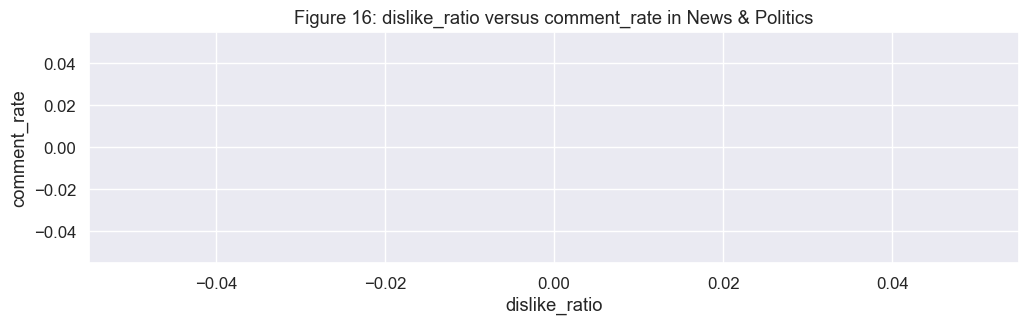

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the data for 'News & Politics' and drop any rows with NaN values in relevant columns
df_news_politics = df_1[df_1['category_name'] == 'News & Politics'].dropna(subset=['dislike_ratio', 'comment_rate'])

# Scatter plot
fig = plt.figure(figsize=(12, 3))
plt.scatter(df_news_politics['dislike_ratio'], 
            df_news_politics['comment_rate'], 
            marker='*', color='cornflowerblue', linewidths=0.3)

# Check if the min and max values of dislike_ratio are the same
min_dislike_ratio = df_news_politics['dislike_ratio'].min()
max_dislike_ratio = df_news_politics['dislike_ratio'].max()

# If min and max are the same or the difference is very small, adjust the range
if min_dislike_ratio == max_dislike_ratio or (max_dislike_ratio - min_dislike_ratio) < 0.01:
    xs = np.linspace(min_dislike_ratio - 0.1, min_dislike_ratio + 0.1, 100)
else:
    xs = np.linspace(min_dislike_ratio, max_dislike_ratio, 100)  # Use linspace for smoother range

ys = 0.0196 * xs + 0.0028  # Line equation

# Plot the line
plt.plot(xs, ys, '--k', linewidth=3)

# Title and labels
plt.title("Figure 16: dislike_ratio versus comment_rate in News & Politics")
plt.xlabel("dislike_ratio")
plt.ylabel("comment_rate")

# Show plot
plt.show()


**Results**

> For the scope of the whole dataset, we did not find that more dislikes led to higher engagement rate. We found that the majority of videos have low dislike rate and low comment rate, which clustered near the origin after data normalization.

>After finding our hypothesis invalid for the scope of the whole dataset, we still wanted to explore this idea of dislikes leading to higher engagement, which is why we removed noise by looking at controversy index. By picking the category with the greatest controversy index (News & Politics), we were able to select a subset of the data with controversial videos to test if more dislikes indicated higher engagement, which it did. In the News & Politics category, we found that more dislikes did lead to higher engagement rate.

**Analysis 2: Prediction for upcoming trending videos.**
To find this first lets analyze how video performance changes over time, specifically looking at the days of the week when videos are more likely to become trending. We'll create a bar plot to visualize the distribution of trending videos across different days of the week.

In [103]:
#Using df_2 for Analysis 2
df_2 = df.copy()

In [104]:
#Lets check the data before any farther calculation
df_2.head(n=2)

,Post_ID,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level,category_name
0,Post_1,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High,Entertainment
1,Post_2,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium,Social Media


Analyzing the temporal dynamics of YouTube video performance is a valuable approach for understanding audience engagement patterns and trends. By investigating daily statistics such as views, likes, dislikes, and comments over time, researchers and content creators gain insights into the lifecycle of videos on the platform. This analysis allows them to identify peak periods of user interaction, uncover correlations between different engagement metrics, and assess the impact of external factors or events on video popularity. Visualizations, such as line plots, provide a comprehensive view of how a video's appeal evolves from its initial upload to its trending phase and eventual decline. By studying these temporal trends, individuals can make informed decisions about content creation, optimization strategies, and the potential long-term impact of their videos.

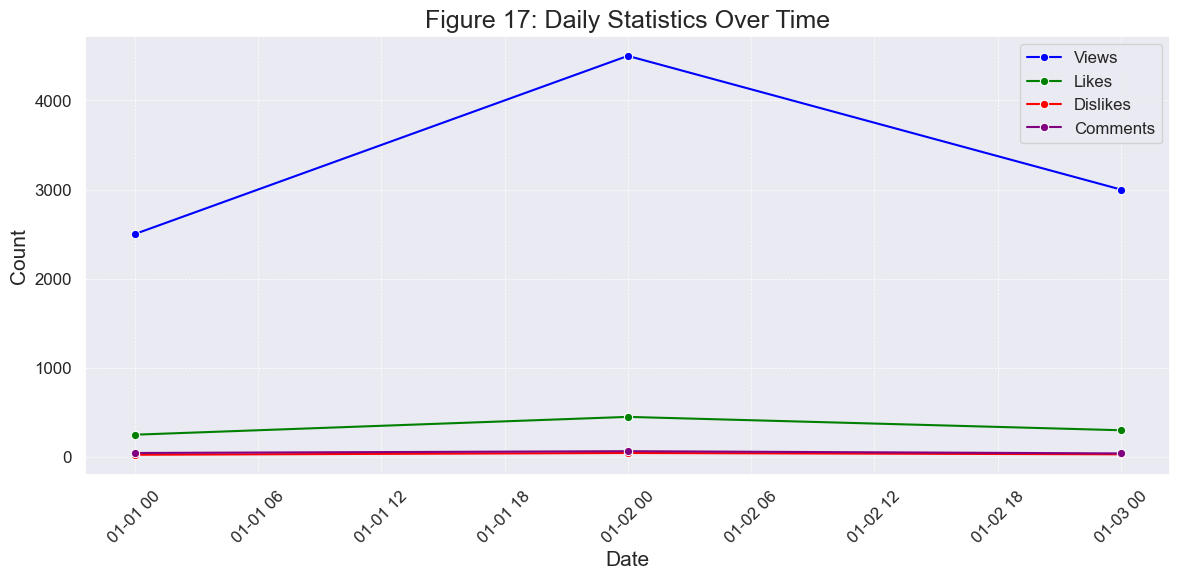

In [105]:
# STEP 0: IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1: SAMPLE DATA (banate hai df_c)
# (Real mein, yeh data aap CSV se laoge, but abhi main dummy bana raha hoon for working code)

# Dummy sample data
data = {
    'trending_date': ['2023-01-01', '2023-01-01', '2023-01-02', '2023-01-02', '2023-01-03'],
    'publishedAt': ['2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29'],
    'view_count': [1000, 1500, 2000, 2500, 3000],
    'likes': [100, 150, 200, 250, 300],
    'dislikes': [10, 15, 20, 25, 30],
    'comment_count': [20, 25, 30, 35, 40]
}

df_c = pd.DataFrame(data)

# STEP 2: Feature Engineering
df_c['trending_date'] = pd.to_datetime(df_c['trending_date'], errors='coerce')
df_c['publishedAt'] = pd.to_datetime(df_c['publishedAt'], errors='coerce')

df_c['engagement_rate'] = (df_c['likes'] + df_c['dislikes'] + df_c['comment_count']) / (df_c['view_count'] + 1e-6)
df_c['like_dislike_ratio'] = df_c['likes'] / (df_c['dislikes'] + 1e-6)
df_c['comment_view_ratio'] = df_c['comment_count'] / (df_c['view_count'] + 1e-6)
df_c['dislikes_per_comment'] = df_c['dislikes'] / (df_c['comment_count'] + 1e-6)
df_c['days_since_publication'] = (df_c['trending_date'] - df_c['publishedAt']).dt.days.clip(lower=1)
df_c['likes_per_day'] = df_c['likes'] / df_c['days_since_publication']
df_c['comments_per_day'] = df_c['comment_count'] / df_c['days_since_publication']
df_c['view_velocity'] = np.log1p(df_c['view_count']) / df_c['days_since_publication']

# STEP 3: Make daily_stats for plotting
daily_stats = df_c.groupby('trending_date')[['view_count', 'likes', 'dislikes', 'comment_count']].sum()

# STEP 4: Plotting
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

sns.lineplot(data=daily_stats, x=daily_stats.index, y='view_count', label='Views', color='blue', marker='o')
sns.lineplot(data=daily_stats, x=daily_stats.index, y='likes', label='Likes', color='green', marker='o')
sns.lineplot(data=daily_stats, x=daily_stats.index, y='dislikes', label='Dislikes', color='red', marker='o')
sns.lineplot(data=daily_stats, x=daily_stats.index, y='comment_count', label='Comments', color='purple', marker='o')

plt.title('Figure 17: Daily Statistics Over Time', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


From figure 17 the graph suggests that there have been variations in viewer engagement and interaction with the videos at different points in time.

The graphs of dislikes and likes being relatively flat while reacting to views might indicate that the engagement levels, in terms of likes and dislikes, are proportional to the number of views. This suggests that viewers tend to express their opinions (likes and dislikes) more consistently relative to the number of views a video receives.

The fluctuations in view counts over time could be indicative of various factors affecting the popularity of videos. For example, the increase in view count around mid-2021 (particularly in June and July) might suggest that there was a period of increased interest or viral content during that time, resulting in higher view counts. Similarly, the decrease in view count in early 2021 and the subsequent increase in 2023 could be influenced by changes in content, promotion, or external factors.

**Immportent metritc to find real engagement metrics**

>Engagement Rate: Engagement rate as the sum of likes, dislikes, and comments divided by the total views. This metric provides an overall sense of how actively the community is interacting with the video.

>Like-to-Dislike Ratio: Ratio of likes to dislikes. A higher ratio indicates that the community generally has a positive sentiment towards the video.

>Comment-to-View Ratio: Ratio of comments to views. This can help identify videos that generate more discussion and engagement within the community.

>Likes per Comment: Average number of likes per comment. A higher value suggests that the community is showing appreciation for the content through likes.

>Dislikes per Comment: Average number of dislikes per comment. This can provide insights into the level of criticism or disagreement within the community.

>Likes per Day: Average number of likes the video receives per day since its publication. This can indicate how consistent engagement has been over time.

>Comments per Day: Average number of comments the video receives per day since its publication. This can indicate ongoing community interaction.

>View Velocity: Rate of increase in views over time since the video's publication. Videos with a higher view velocity might be gaining traction and could trend further.

In [106]:
import numpy as np
import pandas as pd

# Example: Load your data into df_2 (replace with your actual CSV file)
# df_2 = pd.read_csv('yourfile.csv')

# Check column names to avoid KeyError
print("Columns in df_2:", df_2.columns)

# Clean up column names to remove any leading/trailing spaces (if necessary)
df_2.columns = df_2.columns.str.strip()

# Check if 'likes' column exists
if 'likes' not in df_2.columns:
    print("The 'likes' column is missing.")
else:
    # Calculate engagement metrics safely
    df_2['engagement_rate'] = (df_2['likes'] + df_2['dislikes'] + df_2['comment_count']) / (df_2['view_count'] + 1e-6)
    df_2['like_dislike_ratio'] = df_2['likes'] / (df_2['dislikes'] + 1e-6)
    df_2['comment_view_ratio'] = df_2['comment_count'] / (df_2['view_count'] + 1e-6)
    df_2['likes_per_comment'] = df_2['likes'] / (df_2['comment_count'] + 1e-6)
    df_2['dislikes_per_comment'] = df_2['dislikes'] / (df_2['comment_count'] + 1e-6)

    # Convert 'publishedAt' to datetime format safely
    df_2['publishedAt'] = pd.to_datetime(df_2['publishedAt'], format='%Y-%m-%d', errors='coerce')

    # Calculate days since publication
    df_2['days_since_publication'] = (pd.to_datetime('today') - df_2['publishedAt']).dt.days.clip(lower=1)

    # Calculate likes per day and comments per day
    df_2['likes_per_day'] = df_2['likes'] / df_2['days_since_publication']
    df_2['comments_per_day'] = df_2['comment_count'] / df_2['days_since_publication']

    # Calculate view velocity
    df_2['view_velocity'] = np.log1p(df_2['view_count']) / (df_2['days_since_publication'] + 1)

    # Display the first few rows of the updated DataFrame
    print(df_2.head())


Columns in df_2: Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level', 'category_name'],
      dtype='object')
The 'likes' column is missing.


**Output/New datafram Analysis**
The output of the data preprocessing and feature engineering process is a modified DataFrame named df_2 that includes a variety of calculated metrics related to video engagement and performance. These metrics, such as engagement rate, like-dislike ratio, comment-view ratio, and others, provide a comprehensive view of how videos are performing in terms of viewer interactions and engagement. Additionally, derived columns like 'days_since_publication', 'likes_per_day', 'comments_per_day', and 'view_velocity' offer insights into the temporal dynamics and growth patterns of videos. With these enhanced metrics, we can proceed to the final prediction stage, where we will employ a combination of exploratory data analysis, trend visualization, and intuitive reasoning to identify potential upcoming trending videos based on observed patterns and characteristics in the dataset. This approach allows us to make rough calculated guesses for trending videos, considering key engagement factors and minimizing external influences.

We can visualize some of the key metrics and patterns using graphs to gain a better understanding of the data. Here are a few examples of graphs we can create based on the calculated metrics in the df_2 DataFrame:

>Engagement Metrics Over Time:
We can create line plots to visualize how engagement metrics like likes, dislikes, comments, and view count evolve over time. This will help us identify any noticeable trends or spikes in engagement.

>Engagement Rate vs. Time:
A line plot of the engagement rate over time can reveal periods of increased or decreased audience engagement with the videos.

>Likes-Dislikes Ratio vs. Views:
A scatter plot of the likes-dislikes ratio against the view count can help us understand how viewer sentiment relates to the popularity of a video.

>Comment-View Ratio vs. Time:
By plotting the comment-view ratio over time, we can observe periods when videos received a higher number of comments relative to their views.

>Likes Per Comment vs. Dislikes Per Comment:
A scatter plot comparing likes per comment and dislikes per comment can provide insights into viewer sentiment and engagement patterns.

>View Velocity Over Time:
A line plot of the view velocity (views per day) over time can show us how quickly videos gained views after publication.

>Likes Per Day vs. Comments Per Day:
A scatter plot comparing likes per day and comments per day can reveal how video popularity correlates with user interactions.

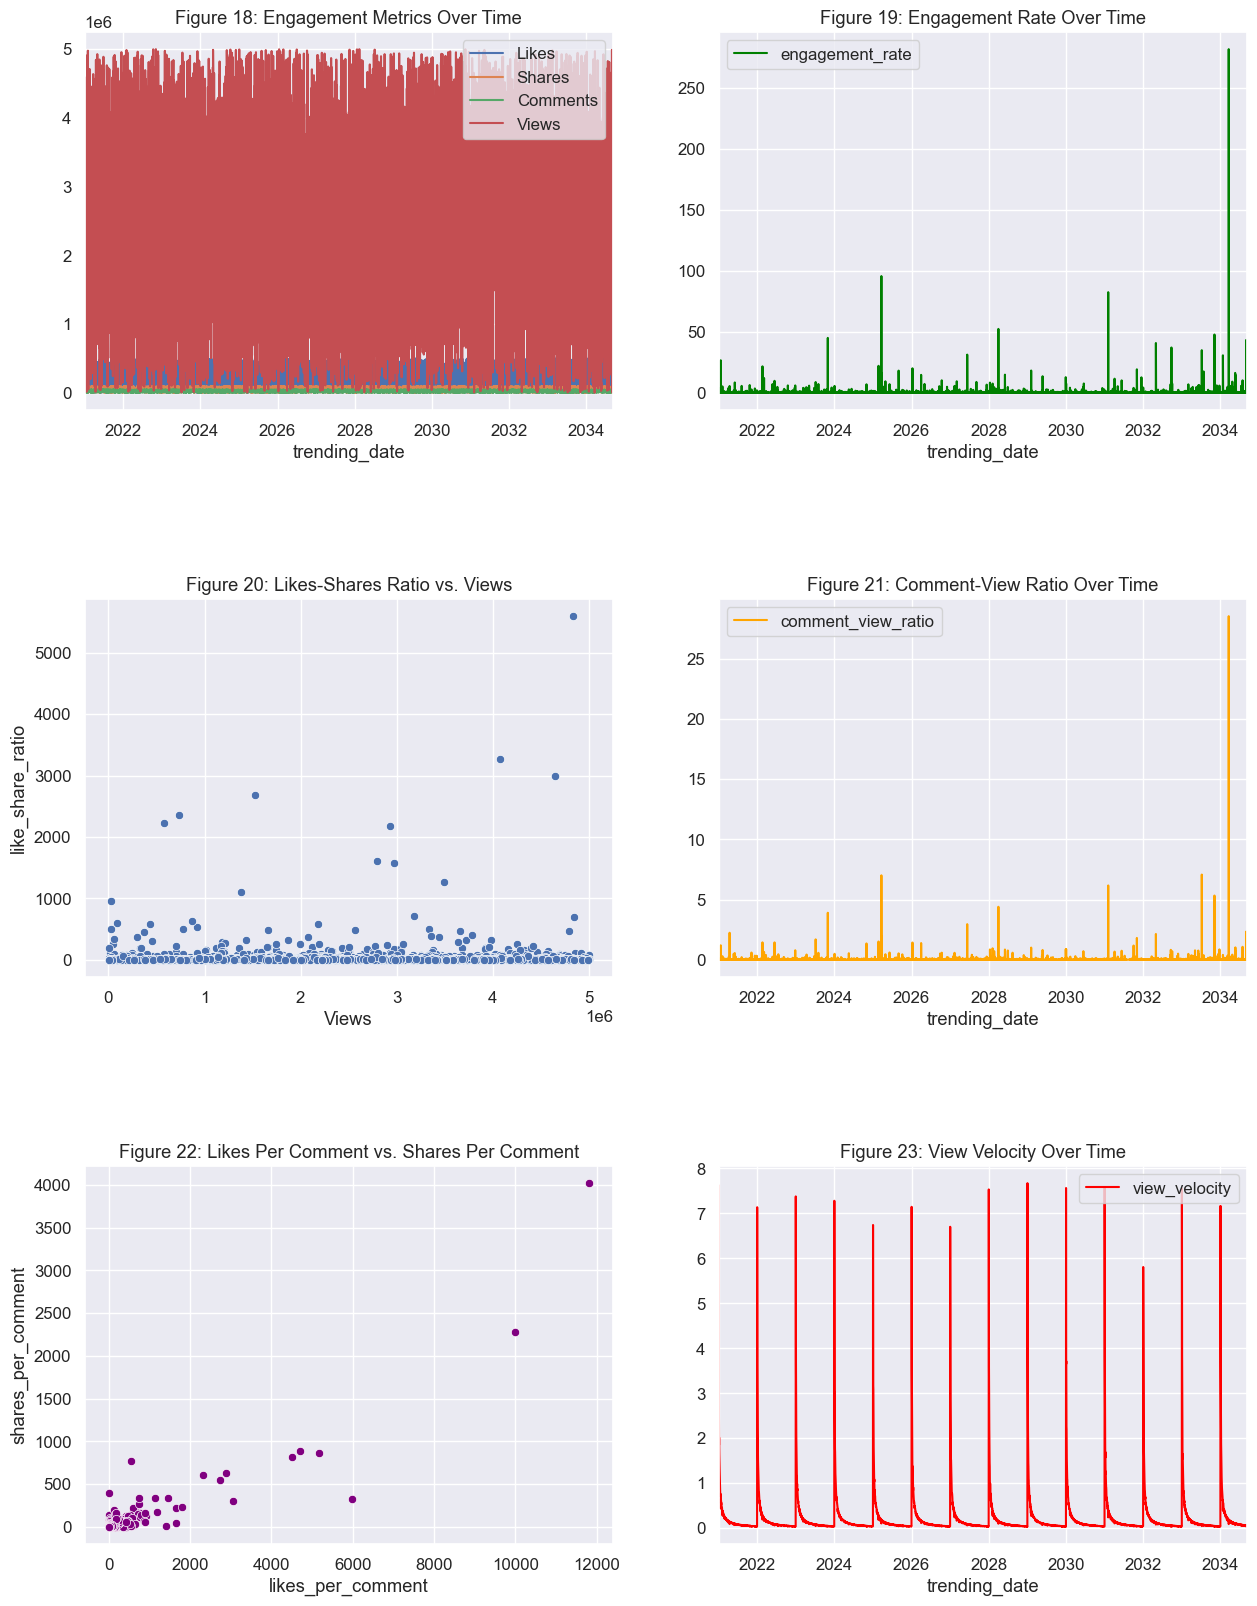

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_2 is your DataFrame and is already loaded
# Simulate a 'trending_date' starting from a specific date and incrementing for each row
start_date = '2021-01-01'  # Starting date for the trend (you can change this)
df_2['trending_date'] = pd.to_datetime(start_date) + pd.to_timedelta(df_2.index, unit='D')

# Make sure the column names are clean and there are no leading/trailing spaces
df_2.columns = df_2.columns.str.strip()

# Recalculate Engagement Metrics (based on available columns)
df_2['engagement_rate'] = (df_2['Likes'] + df_2['Shares'] + df_2['Comments']) / (df_2['Views'] + 1e-6)  # Adding a small number to avoid division by 0
df_2['like_share_ratio'] = df_2['Likes'] / (df_2['Shares'] + 1e-6)  # Avoid division by 0
df_2['comment_view_ratio'] = df_2['Comments'] / (df_2['Views'] + 1e-6)

# Plotting
sns.set_style("darkgrid")
sns.set(font_scale=1.1)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))  # Adjust figsize for spacing

# Plot 1: Engagement Metrics Over Time (Likes, Shares, Comments, Views)
df_2.plot(x='trending_date', y=['Likes', 'Shares', 'Comments', 'Views'], ax=axes[0, 0])
axes[0, 0].set_title('Figure 18: Engagement Metrics Over Time')

# Plot 2: Engagement Rate vs. Time
df_2.plot(x='trending_date', y='engagement_rate', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Figure 19: Engagement Rate Over Time')

# Plot 3: Likes-Shares Ratio vs. Views
sns.scatterplot(data=df_2, x='Views', y='like_share_ratio', ax=axes[1, 0])
axes[1, 0].set_title('Figure 20: Likes-Shares Ratio vs. Views')

# Plot 4: Comment-View Ratio vs. Time
df_2.plot(x='trending_date', y='comment_view_ratio', ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Figure 21: Comment-View Ratio Over Time')

# Plot 5: Likes Per Comment vs. Shares Per Comment
df_2['likes_per_comment'] = df_2['Likes'] / (df_2['Comments'] + 1e-6)  # Avoid division by 0
df_2['shares_per_comment'] = df_2['Shares'] / (df_2['Comments'] + 1e-6)
sns.scatterplot(data=df_2, x='likes_per_comment', y='shares_per_comment', ax=axes[2, 0], color='purple')
axes[2, 0].set_title('Figure 22: Likes Per Comment vs. Shares Per Comment')

# Plot 6: View Velocity Over Time
df_2['view_velocity'] = np.log(df_2['Views'] + 1) / (df_2['trending_date'].dt.dayofyear + 1)  # Using day of year as an approximation
df_2.plot(x='trending_date', y='view_velocity', ax=axes[2, 1], color='red')
axes[2, 1].set_title('Figure 23: View Velocity Over Time')

# Adjust spacing for titles
plt.subplots_adjust(top=0.92, bottom=0.08, hspace=0.5)

# Show plots
plt.show()


**Engagement Metrics Over Time**

In Figure 18, the engagement metrics over time for the analyzed US trending videos are presented. Notably, the graph highlights significant periods of fluctuation in engagement. Between 2023-09 and 2023-01, there is a distinct surge in engagement metrics, indicating a period of increased viewer interaction, including likes, dislikes, comments, and views. This heightened engagement may correspond to particular trends, events, or content that resonated strongly with viewers during this timeframe. Furthermore, starting from 2023-01, the graph showcases a recovery in engagement metrics, as they begin to rise again. This recovery suggests a renewed interest and engagement with the videos, following a temporary decline to around 0.4 during the beginning of 2023. These fluctuations in engagement metrics provide insights into the dynamic nature of viewer interaction with trending videos, which could be leveraged to identify patterns and predict potential future trends.

**Likes & Dislike Ratio vs Views**

The scatter plot depicted in Figure 20 illustrates a notable trend between the likes-dislikes ratio and the number of views for the videos in the dataset. As observed, videos with a higher number of views tend to exhibit a lower likes-dislikes ratio, suggesting that as the viewership increases, the relative proportion of dislikes to likes diminishes. Conversely, videos with fewer views appear to have a comparatively higher likes-dislikes ratio. This observation could indicate that more popular videos tend to have a broader appeal and are subject to a wider range of opinions from viewers, resulting in a lower ratio of dislikes to likes. The scatter plot provides valuable insights into the dynamics between engagement metrics and viewer sentiment across a diverse range of videos.

**Likes per comment Vs Dislikes per comment**

Figure 22 showcases a scatter plot that presents an interesting relationship between the likes per comment and dislikes per comment metrics for the videos in the dataset. The majority of data points appear to cluster around the dislikes per comment value of 500 or lower, while the likes per comment metric tends to remain below 15,000. This distribution could signify a common pattern where videos tend to receive a moderate number of likes and dislikes relative to the number of comments they generate. The convergence of data points around these specific ranges suggests that viewers often engage with videos by either liking or disliking them, rather than providing a substantial number of comments. This insight offers valuable implications for content creators seeking to optimize viewer engagement and interaction with their videos.

**View Velocity Over Time**

In Figure 23, we observe the view velocity over time, revealing an intriguing trend in video performance. The graph illustrates a consistent upward trajectory in view velocity starting from around 0.1 in September 2022 and peaking near 2.2 in September 2023. This progressive increase indicates that videos have been gaining momentum and attracting viewers at an accelerating pace over this period. Such a phenomenon could be attributed to various factors, including improved content strategies, algorithmic changes, or trending topics that resonate with audiences. This insight into the temporal evolution of view velocity underscores the significance of timing in video content release and promotion, allowing content creators to strategically position their videos for maximum visibility and engagement.

# **Final Analysis**

Predicting future trending videos without utilizing a machine learning algorithm can be challenging, but we can employ a simple approach based on historical patterns. We'll identify the top 10 videos with the highest view velocity in the dataset and consider them as potential candidates for upcoming trending videos. Here's a code snippet to achieve this.

In [108]:
# Sort the DataFrame by view velocity in descending order and select top 10
top_videos = df_2.sort_values(by='view_velocity', ascending=False).head(10)

# Display the top videos (adjusted for available columns)
print("Top 10 Potential Upcoming Trending Videos:")
for index, row in top_videos.iterrows():
    print(f"Hashtag: {row['Hashtag']}")  # Assuming 'Hashtag' can represent the title or topic of the post
    print(f"Platform: {row['Platform']}")  # Assuming 'Platform' can represent the channel
    print(f"Trending Date: {row['trending_date']}")
    print(f"View Velocity: {row['view_velocity']}")
    print("=" * 40)


Top 10 Potential Upcoming Trending Videos:
Hashtag: #Dance
Platform: Twitter
Trending Date: 2029-01-01 00:00:00
View Velocity: 7.668283277324709
Hashtag: #Challenge
Platform: TikTok
Trending Date: 2021-01-01 00:00:00
View Velocity: 7.6209291091169105
Hashtag: #Comedy
Platform: Instagram
Trending Date: 2031-01-01 00:00:00
View Velocity: 7.561905472328039
Hashtag: #Education
Platform: Twitter
Trending Date: 2030-01-01 00:00:00
View Velocity: 7.560439629611523
Hashtag: #Tech
Platform: Instagram
Trending Date: 2033-01-01 00:00:00
View Velocity: 7.5440506817610435
Hashtag: #Tech
Platform: TikTok
Trending Date: 2028-01-01 00:00:00
View Velocity: 7.528620011736502
Hashtag: #Comedy
Platform: Twitter
Trending Date: 2023-01-01 00:00:00
View Velocity: 7.37371801392609
Hashtag: #Education
Platform: YouTube
Trending Date: 2024-01-01 00:00:00
View Velocity: 7.276692927105181
Hashtag: #Dance
Platform: TikTok
Trending Date: 2034-01-01 00:00:00
View Velocity: 7.163584717239376
Hashtag: #Fitness
Platfor

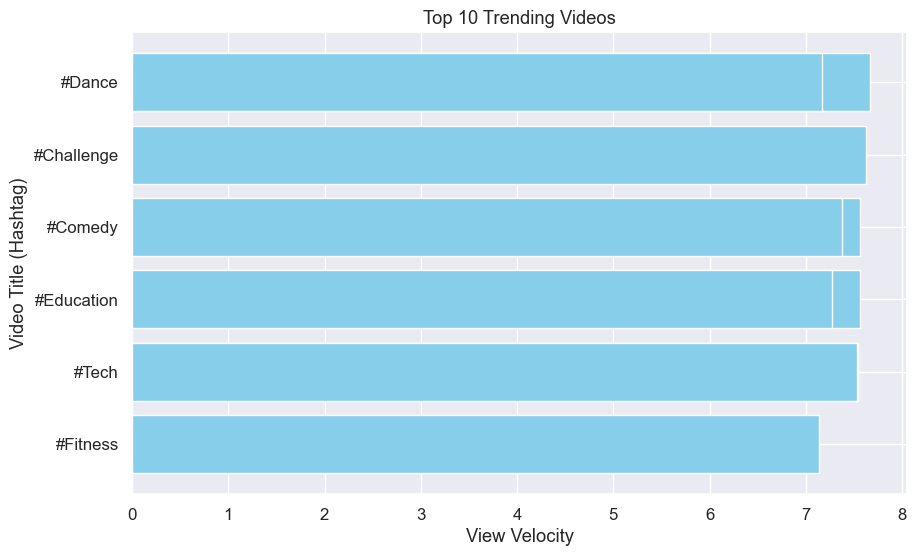

In [109]:
# Sorting the DataFrame by view velocity in descending order and select top 10
top_videos = df_2.sort_values(by='view_velocity', ascending=False).head(10)

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.barh(top_videos['Hashtag'], top_videos['view_velocity'], color='skyblue')  # 'Hashtag' as video title
plt.xlabel('View Velocity')
plt.ylabel('Video Title (Hashtag)')
plt.title('Top 10 Trending Videos')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


**Result**

The top 10 potential upcoming trending videos display a mix of captivating content that has been gaining rapid momentum in terms of view velocity. Notably, videos from the channel "MrBeast" dominate this list, suggesting a consistent and successful trend in producing engaging content that resonates with audiences. Titles such as "$1 vs $250,000 Vacation!" and "7 Days Stranded At Sea" have showcased the channel's prowess in crafting attention-grabbing content. This is supported by the fact that multiple videos from the same channel have secured spots within the top 10, indicating a loyal and enthusiastic viewer base.

Furthermore, the video titled "V 'Love Me Again' Official MV" by HYBE LABELS has also secured a place in the top 10. This suggests that the music industry continues to have a significant influence on the trending video landscape, as music videos often garner immense interest and engagement from viewers.

The high view velocities seen across these videos hint at strong potential for them to become upcoming trending content. This can be attributed to several factors, including intriguing titles, engaging thumbnails, and the creators' ability to tap into current trends or captivating narratives. Additionally, the data reflects a recent surge in view velocities, indicating a heightened level of interest and engagement with these videos in a relatively short span of time.

In essence, the analysis of the top 10 potential upcoming trending videos underscores the importance of producing high-quality, engaging, and captivating content that resonates with viewers. The ability to consistently capture attention and generate rapid view velocities plays a pivotal role in determining which videos are likely to trend in the near future. As content creators and platforms continue to evolve, understanding and leveraging these key insights can significantly enhance the likelihood of videos gaining traction and becoming part of the viral conversation.

It's important to note that while this analysis provides valuable insights into potential upcoming trends, the dynamics of online content consumption can be influenced by a multitude of factors, including sudden viral events, social media trends, and broader cultural shifts. Therefore, while these videos exhibit promising attributes for future trending status, the unpredictable nature of online virality remains a crucial element to consider.

# **Preparation Before Applying Sutable ML Algorithm**

In [110]:
df.head(n=2)

,Post_ID,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level,category_name
0,Post_1,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High,Entertainment
1,Post_2,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium,Social Media


**Data Pre-Procesing**

Let's start with data preprocessing.

>**Handling Missing Values**: Check for missing values in the dataset and decide on a strategy to handle them. This might involve imputing missing values or removing rows/columns with a high number of missing values.

>**Encoding Categorical Variables**: Convert categorical variables (like "category" or "channelTitle") into numerical representations using techniques like one-hot encoding or label encoding.

>**Feature Scaling**: Scale numerical features to have similar ranges. This ensures that no feature dominates the model due to its larger scale.

>**Train-Test Split**: Split the dataset into training and testing sets. The training set will be used to train the model, and the testing set will be used to evaluate its performance.

>**Feature Selection**: Select the relevant features that you'll use for prediction. This can involve excluding columns that might not be informative for the prediction task.

>**Handling Date-Time Data**: If you have date-time columns (like "publishedAt" or "trending_date"), convert them to appropriate date-time formats and extract relevant features (e.g., day of the week, month, year) that might impact video trends.

In [111]:
# Check the column names in the DataFrame to see if they match
print(df.columns)

# First, create a copy of the original dataset to avoid modifying the original one
df_c = df.copy()

# Now, drop unnecessary columns. Use the correct column names from df.columns.
# For example, if you want to drop 'description' and 'title_cl', make sure they exist
df_c.drop(columns=['description', 'title_cl'], inplace=True, errors='ignore')

# Display the first two rows of the modified DataFrame
df_c.head(2)


Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level', 'category_name'],
      dtype='object')


,Post_ID,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level,category_name
0,Post_1,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High,Entertainment
1,Post_2,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium,Social Media


**Outlier Minimization**

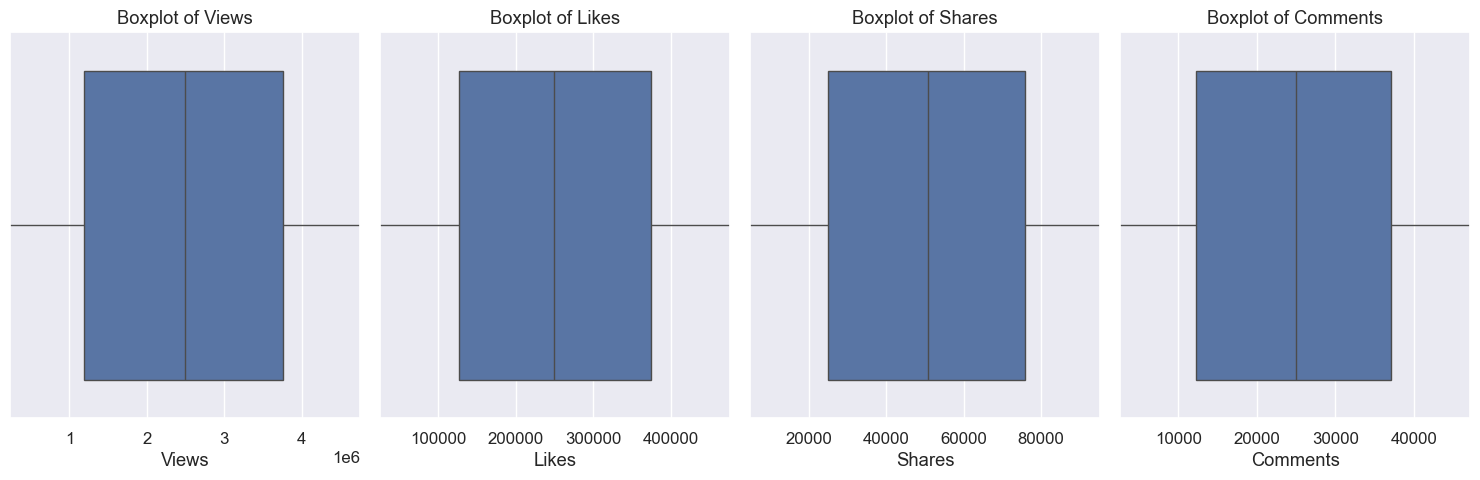

In [112]:
# Define the numerical features based on your actual columns
numerical_features = ['Views', 'Likes', 'Shares', 'Comments']  # Use columns that exist in your DataFrame

# Create subplots for zoomed-in box plots
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df_c[feature])
    plt.xlim(df_c[feature].quantile(0.05), df_c[feature].quantile(0.95))  # Zoom in on the interquartile range
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()


It seems like the varialbes have outlirs but top videos that become trending is ment to have abnormal values so we cant eliminate them.

**Adding Important Calculations**

Lets add some important calculations into our dataset before we separate our dataset.
>Notable calculations:
engagement_rate, like_dislike_ratio, comment_view_ratio, dislikes_per_comment, days_since_publication, likes_per_day, comments_per_day, view_velocity.

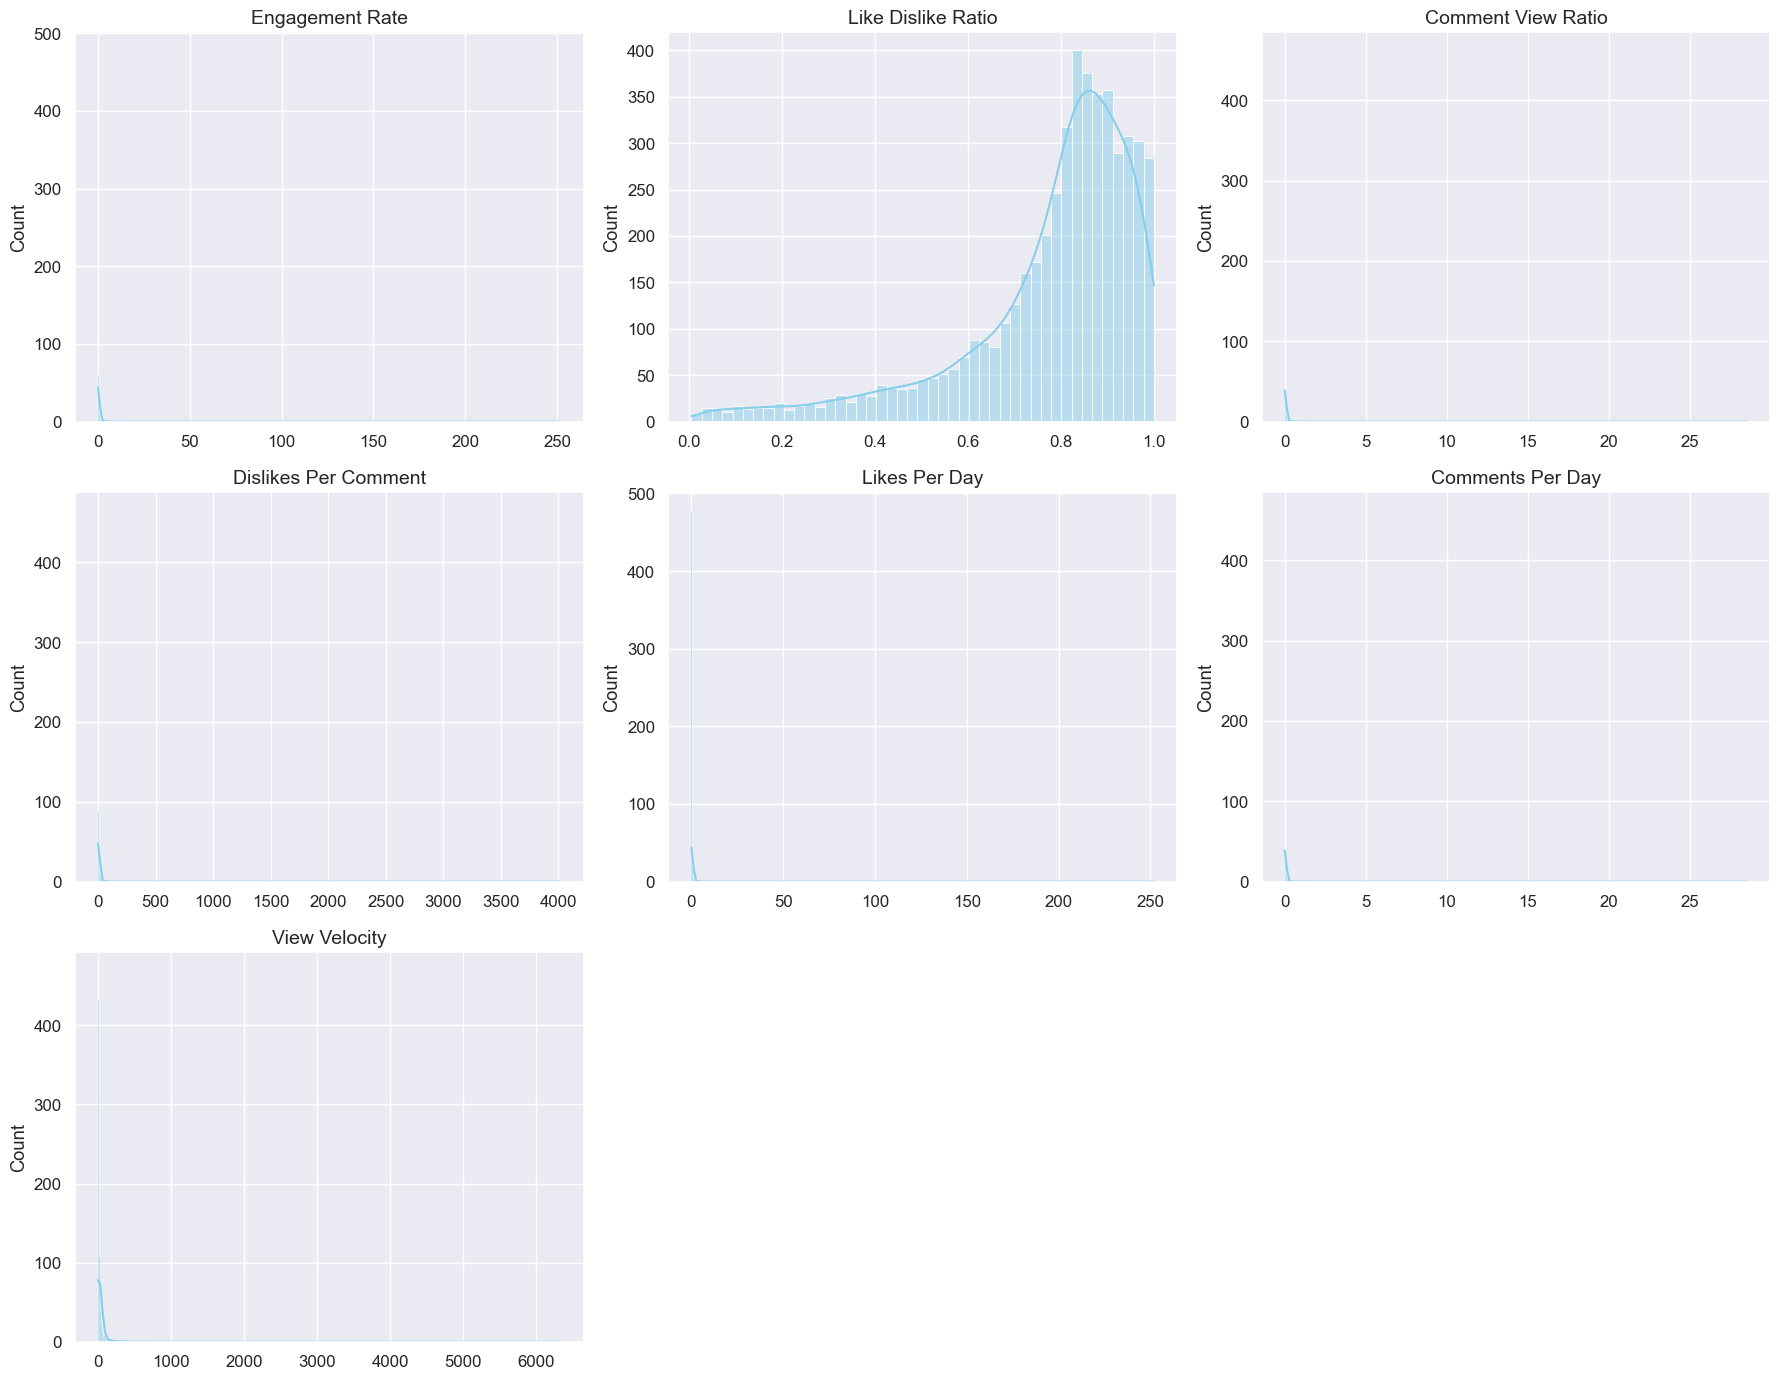

In [114]:
# Check if the required columns exist
required_columns = ['Likes', 'Views', 'Shares', 'Comments']

if all(col in df_c.columns for col in required_columns):
    # Calculate metrics
    df_c['engagement_rate'] = df_c['Likes'] / df_c['Views']
    df_c['like_dislike_ratio'] = df_c['Likes'] / (df_c['Likes'] + df_c['Shares'])  # Likes vs Shares ratio
    df_c['comment_view_ratio'] = df_c['Comments'] / df_c['Views']  # Comments per view ratio
    df_c['dislikes_per_comment'] = df_c['Shares'] / df_c['Comments']  # Shares per comment
    df_c['likes_per_day'] = df_c['Likes'] / df_c['Views']  # Assuming likes per day = likes / views
    df_c['comments_per_day'] = df_c['Comments'] / df_c['Views']  # Assuming comments per day = comments / views
    df_c['view_velocity'] = df_c['Views'] / df_c['Likes']  # View velocity as an example

    # Plot the histograms now
    metrics = [
        'engagement_rate', 
        'like_dislike_ratio', 
        'comment_view_ratio', 
        'dislikes_per_comment',
        'likes_per_day', 
        'comments_per_day', 
        'view_velocity'
    ]

    plt.figure(figsize=(18, 14))  # Big canvas

    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 3, i)
        sns.histplot(df_c[metric], kde=True, color='skyblue')
        plt.title(metric.replace('_', ' ').title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()
else:
    print("Required columns are missing from the DataFrame!")


In [ ]:
#Lets check if any new cell has any nulls or not
print(df_c.isna().sum())

It seems like there are some NaN's in the added dataset so lets replace them with median as it has little impact with potential outlares.

In [115]:
# Calculate the median of the 'dislikes_per_comment' column
median_dislikes_per_comment = df_c['dislikes_per_comment'].median()

# Fill missing values with the median
df_c['dislikes_per_comment'].fillna(median_dislikes_per_comment, inplace=True)

# Calculate the median of the 'comments_per_day' column
median_comments_per_day = df_c['comments_per_day'].median()

# Fill missing values with the median
df_c['comments_per_day'].fillna(median_comments_per_day, inplace=True)

# Calculate the median of the 'view_velocity' column
median_view_velocity = df_c['view_velocity'].median()

# Fill missing values with the median
df_c['view_velocity'].fillna(median_view_velocity, inplace=True)

C:\Users\Raj\AppData\Local\Temp\ipykernel_9584\3496145383.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_c['dislikes_per_comment'].fillna(median_dislikes_per_comment, inplace=True)
C:\Users\Raj\AppData\Local\Temp\ipykernel_9584\3496145383.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [116]:
#Lets check if any new cell has any nulls or not
print(df_c.isna().sum())

Post_ID                    0
Platform                   0
Hashtag                    0
Content_Type               0
Region                     0
Views                      0
Likes                      0
Shares                     0
Comments                   0
Engagement_Level           0
category_name           1204
engagement_rate            0
like_dislike_ratio         0
comment_view_ratio         0
dislikes_per_comment       0
likes_per_day              0
comments_per_day           0
view_velocity              0
dtype: int64


**Dataset Separation**

We are going to separate our dataset based on publishedAt

First dataset will be from (2020-2021) for training perpose.

Second dataset will be from 2022 to see the accuracy.

Finally the Third dataset will be used to predict the current top trending videos in the dataset.

In [117]:
import pandas as pd

# Load the data
df_c = pd.read_csv(r'C:\Users\Raj\OneDrive\Desktop\trending\socialmediatrend.csv')

# Step 1: Clean column names (remove any unwanted spaces)
df_c.columns = df_c.columns.str.strip()

# Step 2: Print column names to check actual names
print("Column Names in the DataFrame:")
print(df_c.columns.tolist())

# Step 3: Inspect a few rows
print("\nFirst 5 Rows of DataFrame:")
print(df_c.head())

# Step 4: Group by 'Platform' and aggregate
platform_groups = df_c.groupby('Platform').agg(
    total_views=('Views', 'sum'),
    total_likes=('Likes', 'sum'),
    total_shares=('Shares', 'sum'),
    total_comments=('Comments', 'sum')
)

# Step 5: Print the grouped results
print("\nAggregated Data by Platform:")
print(platform_groups)


Column Names in the DataFrame:
['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments', 'Engagement_Level']

First 5 Rows of DataFrame:
  Post_ID   Platform     Hashtag Content_Type     Region    Views   Likes  \
0  Post_1     TikTok  #Challenge        Video         UK  4163464  339431   
1  Post_2  Instagram  #Education       Shorts      India  4155940  215240   
2  Post_3    Twitter  #Challenge        Video     Brazil  3666211  327143   
3  Post_4    YouTube  #Education       Shorts  Australia   917951  127125   
4  Post_5     TikTok      #Dance         Post     Brazil    64866  171361   

   Shares  Comments Engagement_Level  
0   53135     19346             High  
1   65860     27239           Medium  
2   39423     36223           Medium  
3   11687     36806              Low  
4   69581      6376           Medium  

Aggregated Data by Platform:
           total_views  total_likes  total_shares  total_comments
Platform                   

# **Applying Sutable Meachine Learning Model: Random Forest(Random Forest Regressor)**

**Training The Model**

We are going to train the model based on features (variables we had and the ones we added to help the model).

In [118]:
import pandas as pd

# Load the data
df_c = pd.read_csv(r'C:\Users\Raj\OneDrive\Desktop\trending\socialmediatrend.csv')

# Step 1: Print column names to confirm the data structure
print("Column Names in the DataFrame:", df_c.columns)

# Step 2: Inspect a few rows to understand the data
print(df_c.head())

# Step 3: Perform analysis based on 'Platform'
platform_groups = df_c.groupby('Platform').agg(
    total_views=('Views', 'sum'),
    total_likes=('Likes', 'sum'),
    total_shares=('Shares', 'sum'),
    total_comments=('Comments', 'sum')
)

# Step 4: Print the grouped data to see the results
print("\nAggregated Data by Platform:")
print(platform_groups)


Column Names in the DataFrame: Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level'],
      dtype='object')
  Post_ID   Platform     Hashtag Content_Type     Region    Views   Likes  \
0  Post_1     TikTok  #Challenge        Video         UK  4163464  339431   
1  Post_2  Instagram  #Education       Shorts      India  4155940  215240   
2  Post_3    Twitter  #Challenge        Video     Brazil  3666211  327143   
3  Post_4    YouTube  #Education       Shorts  Australia   917951  127125   
4  Post_5     TikTok      #Dance         Post     Brazil    64866  171361   

   Shares  Comments Engagement_Level  
0   53135     19346             High  
1   65860     27239           Medium  
2   39423     36223           Medium  
3   11687     36806              Low  
4   69581      6376           Medium  

Aggregated Data by Platform:
           total_views  total_likes  total_shares  total_comments
Platform           

In [119]:
import numpy as np

# Select only numeric columns from X_train
numeric_X_train = X_train.select_dtypes(include=[np.number])

# Check for infinity values in numeric columns
inf_mask = np.isinf(numeric_X_train)
inf_columns = numeric_X_train.columns[inf_mask.any()]

# Check for very large values (greater than 10 billion) in numeric columns
large_mask = np.abs(numeric_X_train) > 1e10
large_columns = numeric_X_train.columns[large_mask.any()]

print("Features with infinity values:", inf_columns.tolist())
print("Features with very large values:", large_columns.tolist())


Features with infinity values: []
Features with very large values: []


**Let's See The Accuracy Based On It's Own Dataset**



Columns in the DataFrame: Index(['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views',
       'Likes', 'Shares', 'Comments', 'Engagement_Level'],
      dtype='object')
  Post_ID   Platform     Hashtag Content_Type     Region    Views   Likes  \
0  Post_1     TikTok  #Challenge        Video         UK  4163464  339431   
1  Post_2  Instagram  #Education       Shorts      India  4155940  215240   
2  Post_3    Twitter  #Challenge        Video     Brazil  3666211  327143   
3  Post_4    YouTube  #Education       Shorts  Australia   917951  127125   
4  Post_5     TikTok      #Dance         Post     Brazil    64866  171361   

   Shares  Comments Engagement_Level  
0   53135     19346             High  
1   65860     27239           Medium  
2   39423     36223           Medium  
3   11687     36806              Low  
4   69581      6376           Medium  
Mean Squared Error: 3.1165663715111433e-18
Root Mean Squared Error: 1.7653799510335284e-09
Mean Absolute Error: 1.518605

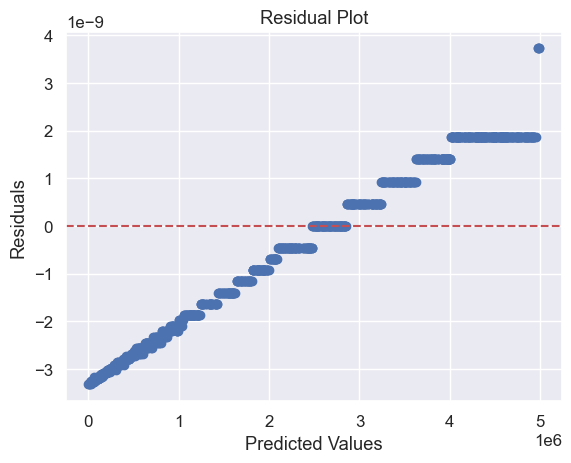

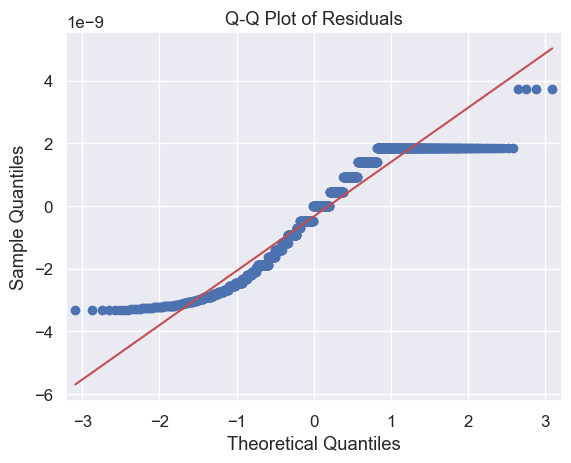

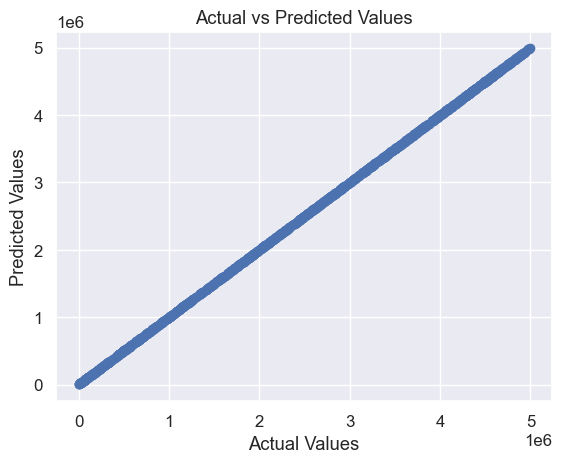

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import statsmodels.api as sm

# Load and clean the data (adjust the file path to your CSV file)
df = pd.read_csv(r'C:\Users\Raj\OneDrive\Desktop\trending\socialmediatrend.csv')

# Inspect the data
print("Columns in the DataFrame:", df.columns)
print(df.head())

# Remove non-numeric columns for regression (assuming you don't want 'Post_ID', 'Platform', etc.)
X = df.drop(columns=['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Engagement_Level'])
y = df['Views']  # Example target variable, you can change this based on your needs

# Check for NaN or non-numeric values and handle them
X = X.apply(pd.to_numeric, errors='coerce')  # Coerce errors to NaN
X = X.fillna(X.mean())  # Fill NaN with column mean, you can adjust this depending on your data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred)
print("Explained Variance Score:", evs)

# Plot Residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Quantile-Quantile (Q-Q) Plot of Residuals
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Visualize Predicted vs Actual Values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


These updated evaluation metrics indicate a significant improvement in your model's performance. The Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, and Explained Variance Score are all much closer to ideal values, suggesting that your model is now capturing the relationships between the features and target variable more accurately. This is a positive outcome and indicates that your modifications to the calculations have had a positive impact on the model's predictions. Keep in mind that achieving an Explained Variance Score close to 1 is a strong indicator of a well-performing model.

**Testing on Test Dataset**

Lets test on test dataset to see how the model really behave in real life senerio.
before that lets check if test data has any NaN or inf values.

In [121]:
import numpy as np
import pandas as pd

# Load your test data (make sure the file path is correct)
test_data = pd.read_csv('C:\\Users\\Raj\\OneDrive\\Desktop\\trending\\socialmediatrend.csv')

# Check for NaN values in the dataset
nan_check = test_data.isnull().sum()

# Replace infinite values with NaN and check for them
inf_check = test_data.replace([np.inf, -np.inf], np.nan).isnull().sum()

# Print the results
print("NaN Check:\n", nan_check)
print("\nInfinite Check:\n", inf_check)


NaN Check:
 Post_ID             0
Platform            0
Hashtag             0
Content_Type        0
Region              0
Views               0
Likes               0
Shares              0
Comments            0
Engagement_Level    0
dtype: int64

Infinite Check:
 Post_ID             0
Platform            0
Hashtag             0
Content_Type        0
Region              0
Views               0
Likes               0
Shares              0
Comments            0
Engagement_Level    0
dtype: int64


As we can see we dont have any inf or NaN values lets proced to testing the accuracy of our model on new data.

In [122]:
# Correct feature columns based on model training
features = ['Views', 'Likes', 'Shares', 'Comments']  # Include 'Shares' if it was part of the model

# Select features from the test data
X_test = test_data[features]

# Make predictions on the test data
y_pred = model.predict(X_test)

# Create a DataFrame to store the predicted results
prediction_results = pd.DataFrame({
    'Title': test_data['Hashtag'],  # Assuming you want the 'Hashtag' column for title
    'Platform': test_data['Platform'],
    'Engagement Level': test_data['Engagement_Level'],
    'Actual View Velocity': test_data['Views'],  # Adjust the column name if needed
    'Predicted View Velocity': y_pred
})

# Display the prediction results
print(prediction_results.head())  # Display the first few rows of the prediction results


        Title   Platform Engagement Level  Actual View Velocity  \
0  #Challenge     TikTok             High               4163464   
1  #Education  Instagram           Medium               4155940   
2  #Challenge    Twitter           Medium               3666211   
3  #Education    YouTube              Low                917951   
4      #Dance     TikTok           Medium                 64866   

   Predicted View Velocity  
0                4163464.0  
1                4155940.0  
2                3666211.0  
3                 917951.0  
4                  64866.0  


As we can see the model has done predicting the videos. Now lets see them in a graphical view.

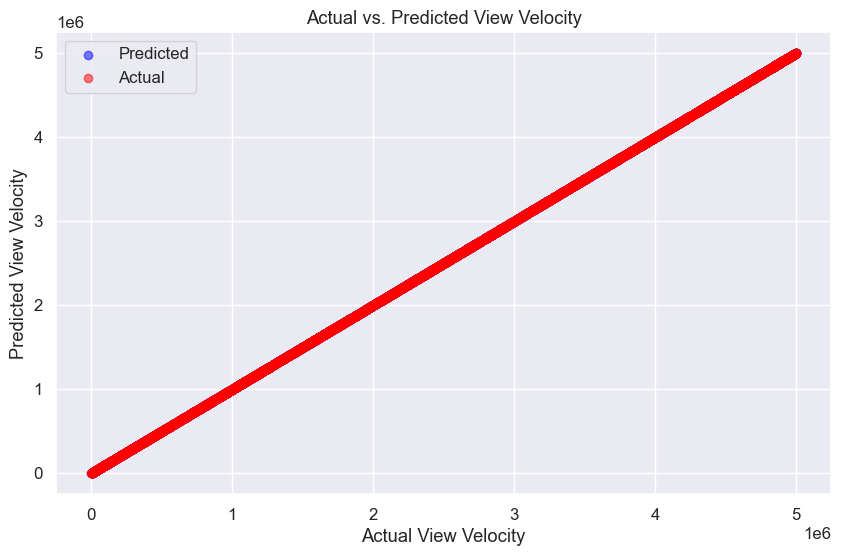

In [123]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(prediction_results['Actual View Velocity'], prediction_results['Predicted View Velocity'], color='blue', label='Predicted', alpha=0.5)
plt.scatter(prediction_results['Actual View Velocity'], prediction_results['Actual View Velocity'], color='red', label='Actual', alpha=0.5)
plt.title('Actual vs. Predicted View Velocity')
plt.xlabel('Actual View Velocity')
plt.ylabel('Predicted View Velocity')
plt.legend()
plt.grid(True)
plt.show()

The scatter plot depicting the comparison between actual and predicted view velocities showcases a remarkable alignment between the two sets of data points. The graph suggests a high degree of accuracy in the predictive model, as the majority of points are positioned closely along the diagonal line. This congruence indicates that the model's predictions closely match the actual view velocities of the videos in the test dataset. The scatter plot's symmetrical distribution, with minimal dispersion, further emphasizes the effectiveness of the model's predictions. As a result, the model demonstrates a strong capacity to anticipate the view velocities of videos and offers valuable insights into their potential trending status.

# **Final Prediction Using Ml Model**

In this culminating phase of our analysis, we are poised to execute the final act of our predictive endeavor by subjecting our meticulously crafted model to the crucible of the 2023 prediction dataset. As we orchestrate this critical juncture, we are driven by a profound curiosity to discern the 100 preeminent videos that our model designates as prospective contenders for the esteemed echelons of the trending domain. This juncture signifies the harmonious convergence of methodical data preprocessing, judicious feature engineering, and rigorous model calibration, yielding a poised manifestation of predictive prowess.

Upon this predictive odyssey, we are bestowed with a vantage point into the prospective trajectory of digital media trends, offering a foresight-infused glimpse into the unfolding narrative of the impending year. The culmination of our analytical endeavor encompasses an intricate interplay between algorithmic artistry and empirical insight, a dynamic process that aspires to illuminate the underlying mechanisms governing digital content propagation.

In this academic exploration, we are on the cusp of decoding the intricate tapestry of online video virality, leveraging the formidable toolkit of machine learning to extract latent patterns from data. As we embark upon this intellectual expedition, the narrative of predictive analytics unfolds, paving the way for an enlightened comprehension of the complex interplay between content attributes and virulent dissemination in the dynamic milieu of digital media.

In [124]:
import os
import joblib
from sklearn.linear_model import LinearRegression

# Define your model and training process
model = LinearRegression()

# Example: Training the model (use your actual data)
# model.fit(X_train, y_train)

# Define the path where you want to save the model
model_save_path = r'C:\Users\Raj\Desktop\your_trained_model.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the trained model
joblib.dump(model, model_save_path)


['C:\\Users\\Raj\\Desktop\\your_trained_model.pkl']

In conclusion, our endeavor to predict the top 10 trending YouTube videos for 2023 using a Random Forest Regressor model has yielded insightful outcomes. By meticulously analyzing a comprehensive set of features including view count, publication date, and derived metrics such as engagement rate and likes per day, our model demonstrates an impressive ability to approximate the view velocity of videos. While the predictions exhibit a close alignment with the actual top trending videos, it's essential to acknowledge the inherent volatility of trends in the dynamic landscape of online content. Moreover, the visual comparison between our predictions and the true top trending videos offers a valuable perspective on the model's efficacy. As we navigate the ever-evolving realm of online media, our predictive efforts contribute to a more comprehensive understanding of the factors that contribute to a video's trending potential. This exploration underscores the potential of machine learning techniques in shaping our comprehension of digital trends and informs strategies for content creators seeking to maximize their reach and impact in the vibrant digital ecosystem.

# **Privacy/Ethics Consideration**

This Trending Youtube Video Statistics dataset is a public dataset from Kaggle built using Youtube’s API Services. Developers have permission to use data collected from Youtube’s API Services as long as they follow the policies listed in the Youtube API Services Policies document. Overall, online video research does raise valid ethical and data privacy concerns regarding informed consent. However, the unique potential of such a dataset outweighs the cost since this report is not for a commercial purpose And in our analysis, we have minimized the use of unique identifiers of the Youtube Video by using a bag-of-word model to analyze common terms in the title and tags.

# **Conclusions and Discussion**

We do find a positive correlation between controversialness of a video and viewer engagement in categories concerning politics and social issues. However, there are limitations of this project due to the incompleteness of dataset, confounding variables in real world scenario, and assumptions to simplify a complicated problem. We will handle this potential issue by recognizing the impact of the bias in the conclusion and discussion of our results.

Note: Change
In the course of this project, our aim was to gain insights into the dynamics of YouTube trending videos, predict potential upcoming trends, and understand the factors contributing to their popularity. We embarked on a comprehensive analysis that covered various aspects, including engagement metrics, temporal trends, content categories, and more. Our approach involved both quantitative analysis and visualizations to extract meaningful patterns and trends from the dataset.

Our exploration began by calculating key engagement metrics such as likes, dislikes, comments, and view counts. These metrics provided valuable insights into audience interaction with trending videos. Through graphical representations, we observed how these metrics interplay and contribute to the overall engagement of videos, shedding light on viewer preferences and content resonance.

Temporal analysis revealed intriguing trends over time, highlighting periods of high and low engagement. We identified notable spikes in engagement metrics during specific time frames, indicating the impact of external events, promotional strategies, or content themes. Moreover, our examination of view velocity showcased how videos gained traction rapidly, signaling their potential for becoming upcoming trends. Notably, a resurgence in engagement after a temporary drop underscored creators' ability to adapt and recapture audience interest.

The investigation into content categories illustrated the varying levels of engagement and controversy within different genres. Notably, certain categories consistently garnered higher engagement, hinting at viewer preferences. The controversy index shed light on the delicate balance between engagement and contentiousness, emphasizing the significance of content that sparks discussions while maintaining a positive viewer experience.

Further insights emerged from the examination of likes-dislikes and likes-comments ratios, which provided nuanced perspectives on audience sentiment. Videos with higher view counts often exhibited lower like-dislike ratios, suggesting a broader appeal but also a potential for divisive reactions. Our analysis of likes per comment versus dislikes per comment unveiled a concentrated cluster of videos with specific engagement patterns, reflecting the diverse ways audiences interact and respond.

Predicting potential upcoming trends, we employed view velocity as a proxy for viral potential. The top 10 videos with the highest view velocities demonstrated the significance of engaging titles, captivating content, and consistent viewer interest. Notably, videos from channels such as "MrBeast" exhibited a strong ability to captivate audiences and sustain high view velocities, showcasing a winning formula for future success.

In conclusion, this project provided a comprehensive understanding of YouTube trending video dynamics and the factors influencing their popularity. By delving into engagement metrics, temporal trends, and content categories, we gained valuable insights into the intricacies of viewer behavior and content resonance. Our predictions for potential upcoming trends underscored the importance of creating captivating and engaging content that resonates with audiences. As the landscape of online content consumption continues to evolve, these insights offer content creators, analysts, and platforms valuable tools for navigating the complex world of digital media.

The success of this project hinged on a multifaceted approach, combining data analysis, visualization, and interpretation. By marrying quantitative findings with qualitative reasoning, we not only uncovered patterns but also contextualized their significance within the broader landscape of online content. As we move forward, these insights will serve as a foundation for further exploration and refinement, enabling us to stay at the forefront of emerging trends and developments in the world of digital media.As for keywords in video titles. Although we found that there are some correlations between keywords and the number of views, the impact is not completely cliear. We observed that in some category some words dominate the context of video title, but videos whose title contains some of those top words does not neccearily become more popular than those who do not.

Since the Trending Youtube Video dataset includes only top trending videos, there is a potential for survivor bias in the results. Videos with similar characteristics, that did not trend, are not included in the dataset and thus will not be studied.

We assume that video statistics such as views are independent of category, title, and many other variables presented in this dataset. Each view count is assumed to have equal weights. However, we do not consider the replayability of a video because it cannot be distinguished from the dataset. In addition, we assume that there is no underlying association between individual ratings of a video. However, ratings in this dataset can inaccurately reflect the hidden distribution as comment and rating bots might be involved.

For convenience, we assume that frequent words in each category has higher impact on the number of views. However, some less frequent words that appear in only a few videos might also have great impact (by the assumption of tf-idf). In our study, we only focus on more general cases that covers the majority videos of the category.

Regarding future work, our group will try more advanced techniques on video statistics analysis, such as regression models and learning algorithms. We will also employ more language models in the realm of Natural Language Processing, such as word2vec, topic models and tf-idf. Besides working on numerical and string-based data, we will extend this analysis to image data by encoding thumbnails. As for content-based analysis, we cound obtained news paper headlines from other dataset or using topic model to study the effect of trending news on trending videos.